In [1]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [2]:
import keras
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from sklearn import preprocessing

from cataclop.ml import preprocessing as cataclop_preprocessing

In [3]:
from cataclop.ml.pipeline import factories

dataset = factories.Dataset.factory('default', params={
    "from": "2018-01-01",
    "to": "2019-12-31"
})
dataset.load(force=True)

30069 races


In [1080]:
race_features = ['prize', 'declared_player_count']
race_features += ['odds_{:d}'.format(i) for i in range(10)]


horse_features = ['age', 'final_odds_ref', 'final_odds_ref_r'] + ['hist_{}_pos'.format(i+1) for i in range(6)]

for f in dataset.agg_features:
        if f.startswith('final_odds'):
            continue
        horse_features.append(f)
        horse_features.append('{}_r'.format(f))
        #horse_features.append('{}_std'.format(f))
        horse_features.append('{}_mean'.format(f))
        #for s in dataset.agg_features_funcs:
            #features.append('{}_{}'.format(f, s[0]))

horse_cat_features = ['horse_sex', 'horse_breed']
race_cat_features = ['category', 'sub_category']

race_features = sorted(list(set(race_features)))
horse_features = sorted(list(set(horse_features)))
horse_cat_features = sorted(list(set(horse_cat_features)))
race_cat_features = sorted(list(set(race_cat_features)))

features = race_features + horse_features
cat_features = race_cat_features + horse_cat_features

print(len(features), features)
print(len(cat_features), cat_features)


78 ['declared_player_count', 'odds_0', 'odds_1', 'odds_2', 'odds_3', 'odds_4', 'odds_5', 'odds_6', 'odds_7', 'odds_8', 'odds_9', 'prize', 'age', 'final_odds_ref', 'final_odds_ref_r', 'handicap_distance', 'handicap_distance_mean', 'handicap_distance_r', 'handicap_weight', 'handicap_weight_mean', 'handicap_weight_r', 'hist_1_days', 'hist_1_days_mean', 'hist_1_days_r', 'hist_1_pos', 'hist_1_pos_mean', 'hist_1_pos_r', 'hist_2_days', 'hist_2_days_mean', 'hist_2_days_r', 'hist_2_pos', 'hist_2_pos_mean', 'hist_2_pos_r', 'hist_3_days', 'hist_3_days_mean', 'hist_3_days_r', 'hist_3_pos', 'hist_3_pos_mean', 'hist_3_pos_r', 'hist_4_pos', 'hist_5_pos', 'hist_6_pos', 'placed_2_count', 'placed_2_count_mean', 'placed_2_count_r', 'placed_3_count', 'placed_3_count_mean', 'placed_3_count_r', 'placed_earnings', 'placed_earnings_mean', 'placed_earnings_r', 'post_position', 'post_position_mean', 'post_position_r', 'prev_year_earnings', 'prev_year_earnings_mean', 'prev_year_earnings_r', 'race_count', 'race_c

In [1081]:
NAN_FLAG = 0

df = dataset.players.copy()
df = df.groupby('race_id').filter(lambda r: (r['trueskill_mu'] == 25).sum() < r['declared_player_count'].max()/2 and r['position'].min() == 1 and r['winner_dividend'].max() > 0 and r['odds_0'].min() != dataset.params['nan_flag'] and r['odds_1'].min() != dataset.params['nan_flag'] )
#df = df.groupby('race_id').filter(lambda r: r['position'].min() == 1 and r['winner_dividend'].max() > 0 and r['odds_0'].min() != dataset.params['nan_flag'] and r['odds_1'].min() != dataset.params['nan_flag'] )
df.reset_index(inplace=True)
df.loc[:, features] = df.loc[:, features].fillna(NAN_FLAG)

df['position'] = df['position'].fillna(20)

scaler = preprocessing.RobustScaler() 
scaled = scaler.fit_transform(df.loc[:, features].values)

df['final_odds_ref_real'] = df['final_odds_ref'].copy()
df['declared_player_count_real'] = df['declared_player_count'].copy()
df['prize_real'] = df['prize'].copy()
df.loc[:, features] = scaled

In [1082]:
horse_dummies = cataclop_preprocessing.get_dummies(df, horse_cat_features, limit=5)

df_horse_dummies = cataclop_preprocessing.get_dummy_values(df, horse_dummies)

df = pd.concat([df, df_horse_dummies], axis=1)

race_dummies = cataclop_preprocessing.get_dummies(df, race_cat_features, limit=5)

df_race_dummies = cataclop_preprocessing.get_dummy_values(df, race_dummies)

df = pd.concat([df, df_race_dummies], axis=1)


all_horse_features = sorted(list(set(horse_features + list(df_horse_dummies.columns))))

all_race_features = sorted(list(set(race_features + list(df_race_dummies.columns))))

print(len(all_horse_features), all_horse_features)
print(len(all_race_features), all_race_features)

df = df.loc[:,~df.columns.duplicated()]

76 ['age', 'final_odds_ref', 'final_odds_ref_r', 'handicap_distance', 'handicap_distance_mean', 'handicap_distance_r', 'handicap_weight', 'handicap_weight_mean', 'handicap_weight_r', 'hist_1_days', 'hist_1_days_mean', 'hist_1_days_r', 'hist_1_pos', 'hist_1_pos_mean', 'hist_1_pos_r', 'hist_2_days', 'hist_2_days_mean', 'hist_2_days_r', 'hist_2_pos', 'hist_2_pos_mean', 'hist_2_pos_r', 'hist_3_days', 'hist_3_days_mean', 'hist_3_days_r', 'hist_3_pos', 'hist_3_pos_mean', 'hist_3_pos_r', 'hist_4_pos', 'hist_5_pos', 'hist_6_pos', 'horse_breed_value_ANGLO ARABE', 'horse_breed_value_AQPS', 'horse_breed_value_PUR-SANG', 'horse_breed_value_TROTTEUR ETRANGER', 'horse_breed_value_TROTTEUR FRANCAIS', 'horse_sex_value_ANGLO ARABE', 'horse_sex_value_AQPS', 'horse_sex_value_PUR-SANG', 'horse_sex_value_TROTTEUR ETRANGER', 'horse_sex_value_TROTTEUR FRANCAIS', 'placed_2_count', 'placed_2_count_mean', 'placed_2_count_r', 'placed_3_count', 'placed_3_count_mean', 'placed_3_count_r', 'placed_earnings', 'placed

In [1083]:
race_ids = df['race_id'].unique()
test_portion = int(len(race_ids) * 0.2)
test_race_ids = race_ids[0:test_portion]
train_race_ids = race_ids[test_portion+1:]

df_train = df[df['race_id'].isin(train_race_ids)].copy()
df_test = df[df['race_id'].isin(test_race_ids)].copy()

print(len(test_race_ids), len(train_race_ids))

3403 13613


In [1084]:
def make_Xy(df, train=True):
    
    X = df[sorted(all_horse_features + all_race_features)]

    y1 = np.log(1+ (df['position'] / df['declared_player_count_real']))
    y2 = np.clip((df['winner_dividend'] / 100), 0, 60) / 60
    y3 = np.clip((df['placed_dividend'] / 100), 0, 30) / 30

    y = np.transpose(np.array([y1, y2, y3]))
                
    return (X, y)

In [1085]:
X, y = make_Xy(df_train)

In [801]:
y

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       ...,
       [0.        , 0.01833333],
       [0.        , 0.        ],
       [0.        , 0.        ]])

In [1044]:
X[0:5]

,age,category_value_ATTELE,category_value_HAIE,category_value_MONTE,category_value_PLAT,category_value_STEEPLECHASE,declared_player_count,handicap_distance,handicap_distance_mean,handicap_distance_r,...,trueskill_mu_r,trueskill_sigma,trueskill_sigma_mean,trueskill_sigma_r,victory_count,victory_count_mean,victory_count_r,victory_earnings,victory_earnings_mean,victory_earnings_r
42003,-0.666667,0.0,0.0,0.0,1.0,0.0,-1.2,-0.836364,-0.83305,0.0,...,-0.772787,2.184604,1.079839,1.241619,-0.50,-0.806189,-0.302375,-1.478576,-2.456542,0.086342
42004,-0.666667,0.0,0.0,0.0,1.0,0.0,-1.2,-0.836364,-0.83305,0.0,...,0.402869,0.811033,1.079839,-0.037645,-0.50,-0.806189,-0.302375,-1.529572,-2.456542,0.073698
42005,-0.666667,0.0,0.0,0.0,1.0,0.0,-1.2,-0.836364,-0.83305,0.0,...,-0.174659,-0.176071,1.079839,-0.956975,-0.50,-0.806189,-0.302375,-1.201770,-2.456542,0.154977
42006,-0.666667,0.0,0.0,0.0,1.0,0.0,-1.2,-0.836364,-0.83305,0.0,...,1.460775,1.154796,1.079839,0.282516,-0.25,-0.806189,1.136807,-0.493836,-2.456542,0.330511
42007,-0.666667,0.0,0.0,0.0,1.0,0.0,-1.2,-0.836364,-0.83305,0.0,...,-0.772787,2.184604,1.079839,1.241619,-0.50,-0.806189,-0.302375,-1.826379,-2.456542,0.000104


In [1045]:
X[0:1].values

array([[-6.66666667e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        -1.20000000e+00, -8.36363636e-01, -8.33050368e-01,
         0.00000000e+00,  0.00000000e+00,  2.42537313e-01,
        -1.00001099e+00,  0.00000000e+00,  2.30300661e-01,
         9.99997849e-01, -5.71428571e-01, -1.20378788e+00,
        -5.17733409e-01,  0.00000000e+00,  3.29754652e-01,
         9.99991455e-01, -8.57142857e-01, -2.30970809e+00,
        -4.73053155e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -8.57142857e-01, -2.79103053e+00,
        -3.16047261e-01, -8.57142857e-01, -6.25000000e-01,
        -6.25000000e-01,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.22222222e-01,
        -5.00000000e-01, -7.20000000e-01, -9.35483871e-01,
        -1.15384615e+00,  1.03703704e+00,  1.78947368e+0

In [197]:
(pd.DataFrame(y)).describe()

,0,1,2
count,279932.000000,279932.000000,279932.000000
mean,0.467535,0.011794,0.012398
std,0.273800,0.060980,0.032317
min,0.040822,0.000000,0.000000
25%,0.251314,0.000000,0.000000
50%,0.435318,0.000000,0.000000
75%,0.624154,0.000000,0.000000
max,1.791759,1.000000,1.000000


In [1033]:
(X.shape, X_test.shape)

((174010, 96), (41991, 96))

In [13]:
#X = np.reshape(X, (X.shape[0], X.shape[1], 1))
#X = np.reshape(X, (X.shape[0], X.shape[1]))

In [1086]:
X_test, y_test = make_Xy(df_test, train=False)

In [806]:
(y.shape, y_test.shape)

((279932, 2), (68814, 2))

In [20]:
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

In [429]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

In [1087]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import metrics

from skopt.space import Real, Integer

from skopt.utils import use_named_args

from skopt.space import Real, Integer, Categorical

model = Sequential()

fspace = [Integer(5, 100, name='n'),
          Real(0, 0.9, "uniform", name='dropout'),
          Categorical(('sigmoid', 'tanh', 'relu'), name='activation'),
          Integer(1, 30, name='epochs')]

@use_named_args(fspace)
def f(**params):
    global df_test, model
    global X, y
    
    print(params)
    
    model = Sequential()
    
    model.add(Dense(params['n'], input_dim=X.shape[1]))
    model.add(Dropout(params['dropout']))
    model.add(Activation(params['activation']))

    '''
    model.add(Conv1D(12, 9, input_shape=(X.shape[1], 1)))
    model.add(Activation('sigmoid'))
    #model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(32, 3))
    model.add(Activation('sigmoid'))
    #model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(64, 3))
    model.add(Activation('sigmoid'))
    #model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())

    model.add(Dense(20))
    model.add(Activation('sigmoid'))
    #model.add(Dropout(0.3))
    '''

    model.add(Dense(y.shape[1]))
    model.add(Activation('sigmoid'))

    model.compile(loss='mean_squared_error',
          optimizer='adam')
    
    #checkpointer = ModelCheckpoint(filepath='/tmp/weights.best.hdf5', verbose=1, save_best_only=True, monitor='val_loss')
    model.fit(X, y, batch_size=32, epochs=params['epochs'], validation_data=(X_test, y_test), callbacks=[])
    
    #model.load_weights('/tmp/weights.best.hdf5')
    
    predictions = model.predict(X_test)
    
    p = metrics.mean_absolute_error(y_test, predictions)
    print(p)
    
    return p
    
    
          

In [804]:

X.describe()

,horse_sex_value_PUR-SANG,hist_3_pos_r,post_position_r,trainer_winning_rate_r,handicap_weight,final_odds_ref_r,hist_5_pos,trainer_winning_rate,hist_1_days,hist_1_pos,...,odds_3,sub_category_value_HANDICAP_DIVISE,odds_7,category_value_ATTELE,category_value_HAIE,odds_0,odds_5,sub_category_value_INCONNU,odds_2,odds_8
count,279932.000000,279932.000000,2.799320e+05,279932.000000,279932.000000,279932.000000,279932.000000,279932.000000,279932.000000,279932.000000,...,279932.000000,279932.000000,279932.000000,279932.000000,279932.000000,279932.000000,279932.000000,279932.000000,279932.000000,279932.000000
mean,0.396225,539.545052,3.569441e-20,2253.534578,0.456009,0.390436,0.087877,22653.998634,-21821.251518,0.019189,...,4.023076,0.063730,471.251735,0.495145,0.045736,0.062357,120.965942,0.260006,0.143279,542.339631
std,0.489113,5631.602930,5.726319e-01,15877.684043,0.796156,1.295327,0.472375,140978.332208,41294.272074,0.469509,...,356.339044,0.244271,1890.884316,0.499977,0.208913,0.729059,1462.879006,0.438638,1.042272,1520.473875
min,0.000000,-2.139727,-9.934577e-01,-3.265329,0.000000,-2.992042,-0.500000,0.000000,-100387.000000,-0.857143,...,-2.100000,0.000000,-1.064516,0.000000,0.000000,-1.235294,-1.535714,0.000000,-2.240000,-0.783654
25%,0.000000,-0.468168,-5.000000e-01,-0.261702,0.000000,-0.355941,-0.375000,0.000000,0.000000,-0.428571,...,-0.433333,0.000000,-0.346774,0.000000,0.000000,-0.470588,-0.392857,0.000000,-0.480000,-0.312500
50%,0.000000,0.000182,0.000000e+00,0.001614,0.000000,-0.000016,0.000000,0.000000,0.000000,0.000000,...,0.033333,0.000000,-0.008065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.004808
75%,1.000000,0.531594,5.000000e-01,0.743128,0.952381,0.607995,0.625000,1.000000,0.000000,0.571429,...,0.566667,0.000000,0.645161,1.000000,0.000000,0.529412,0.607143,1.000000,0.560000,0.687500
max,1.000000,59321.539526,1.019871e+00,114140.047836,4.095238,6.737120,0.750000,900000.000000,0.000000,0.571429,...,33330.300000,1.000000,8062.879032,1.000000,1.000000,3.882353,17854.714286,1.000000,41.360000,4806.456731


In [695]:
from skopt import gp_minimize

res_gp1 = gp_minimize(f, fspace, n_calls=50, random_state=0)

print("Best score={}".format(res_gp1.fun))

{'n': 61, 'dropout': 0.7598391737229158, 'activation': 'relu', 'epochs': 26}
Epoch 1/26
8748/8748 [==============================] - 19s 2ms/step - loss: 0.1036 - val_loss: 0.0810
Epoch 2/26
8748/8748 [==============================] - 21s 2ms/step - loss: 0.0900 - val_loss: 0.0804
Epoch 3/26
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0904 - val_loss: 0.0818
Epoch 4/26
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0876 - val_loss: 0.0793
Epoch 5/26
8748/8748 [==============================] - 21s 2ms/step - loss: 0.0846 - val_loss: 0.0776
Epoch 6/26
8748/8748 [==============================] - 21s 2ms/step - loss: 0.0835 - val_loss: 0.0739
Epoch 7/26
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0799 - val_loss: 0.0728
Epoch 8/26
8748/8748 [==============================] - 21s 2ms/step - loss: 0.0795 - val_loss: 0.0728
Epoch 9/26
8748/8748 [==============================] - 21s 2ms/step - loss: 0.0796 - val_loss: 0.0

8748/8748 [==============================] - 19s 2ms/step - loss: 0.0262 - val_loss: 0.0314
Epoch 12/26
8748/8748 [==============================] - 18s 2ms/step - loss: 0.0262 - val_loss: 0.0321
Epoch 13/26
8748/8748 [==============================] - 19s 2ms/step - loss: 0.0262 - val_loss: 0.0320
Epoch 14/26
8748/8748 [==============================] - 19s 2ms/step - loss: 0.0262 - val_loss: 0.0321
Epoch 15/26
8748/8748 [==============================] - 19s 2ms/step - loss: 0.0262 - val_loss: 0.0323
Epoch 16/26
8748/8748 [==============================] - 19s 2ms/step - loss: 0.0262 - val_loss: 0.0326
Epoch 17/26
8748/8748 [==============================] - 19s 2ms/step - loss: 0.0262 - val_loss: 0.0327
Epoch 18/26
8748/8748 [==============================] - 19s 2ms/step - loss: 0.0262 - val_loss: 0.0324
Epoch 19/26
8748/8748 [==============================] - 23s 3ms/step - loss: 0.0262 - val_loss: 0.0326
Epoch 20/26
8748/8748 [==============================] - 21s 2ms/step - loss

8748/8748 [==============================] - 15s 2ms/step - loss: 0.0259 - val_loss: 0.0264
Epoch 18/22
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0260 - val_loss: 0.0264
Epoch 19/22
8748/8748 [==============================] - 15s 2ms/step - loss: 0.0259 - val_loss: 0.0265
Epoch 20/22
8748/8748 [==============================] - 15s 2ms/step - loss: 0.0259 - val_loss: 0.0264
Epoch 21/22
8748/8748 [==============================] - 14s 2ms/step - loss: 0.0259 - val_loss: 0.0265
Epoch 22/22
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0259 - val_loss: 0.0264
0.08636760363854777
{'n': 26, 'dropout': 0.12169635606490688, 'activation': 'sigmoid', 'epochs': 5}
Epoch 1/5
8748/8748 [==============================] - 15s 2ms/step - loss: 0.0271 - val_loss: 0.0262
Epoch 2/5
8748/8748 [==============================] - 16s 2ms/step - loss: 0.0258 - val_loss: 0.0262
Epoch 3/5
8748/8748 [==============================] - 16s 2ms/step - loss: 0.0258 -

Epoch 20/28
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0254 - val_loss: 0.0258
Epoch 21/28
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0254 - val_loss: 0.0258
Epoch 22/28
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0253 - val_loss: 0.0259
Epoch 23/28
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0254 - val_loss: 0.0259
Epoch 24/28
8748/8748 [==============================] - 27s 3ms/step - loss: 0.0254 - val_loss: 0.0259
Epoch 25/28
8748/8748 [==============================] - 23s 3ms/step - loss: 0.0254 - val_loss: 0.0258
Epoch 26/28
8748/8748 [==============================] - 24s 3ms/step - loss: 0.0253 - val_loss: 0.0258
Epoch 27/28
8748/8748 [==============================] - 23s 3ms/step - loss: 0.0253 - val_loss: 0.0257
Epoch 28/28
8748/8748 [==============================] - 23s 3ms/step - loss: 0.0253 - val_loss: 0.0258
0.0852848879203832
{'n': 9, 'dropout': 0.0032091273866791457, 'a

/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


{'n': 100, 'dropout': 0.0, 'activation': 'tanh', 'epochs': 1}
8748/8748 [==============================] - 26s 3ms/step - loss: 0.0274 - val_loss: 0.0262
0.08454186892869986
{'n': 99, 'dropout': 0.8793438501368532, 'activation': 'tanh', 'epochs': 2}
Epoch 1/2
8748/8748 [==============================] - 26s 3ms/step - loss: 0.0375 - val_loss: 0.0330
Epoch 2/2
8748/8748 [==============================] - 26s 3ms/step - loss: 0.0262 - val_loss: 0.0367
0.09446615590155577
{'n': 5, 'dropout': 0.0, 'activation': 'sigmoid', 'epochs': 1}
8748/8748 [==============================] - 21s 2ms/step - loss: 0.0338 - val_loss: 0.0266
0.08725887223263219
{'n': 100, 'dropout': 0.0, 'activation': 'sigmoid', 'epochs': 30}
Epoch 1/30
8748/8748 [==============================] - 24s 3ms/step - loss: 0.0262 - val_loss: 0.0261
Epoch 2/30
8748/8748 [==============================] - 24s 3ms/step - loss: 0.0257 - val_loss: 0.0260
Epoch 3/30
8748/8748 [==============================] - 22s 3ms/step - loss: 0.

8748/8748 [==============================] - 17s 2ms/step - loss: 0.0256 - val_loss: 0.0260
Epoch 9/28
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0256 - val_loss: 0.0259
Epoch 10/28
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0255 - val_loss: 0.0261
Epoch 11/28
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0255 - val_loss: 0.0260
Epoch 12/28
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0255 - val_loss: 0.0260
Epoch 13/28
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0256 - val_loss: 0.0259
Epoch 14/28
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0255 - val_loss: 0.0262
Epoch 15/28
8748/8748 [==============================] - 28s 3ms/step - loss: 0.0254 - val_loss: 0.0260
Epoch 16/28
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0255 - val_loss: 0.0259
Epoch 17/28
8748/8748 [==============================] - 24s 3ms/step - loss:

/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


{'n': 100, 'dropout': 0.0, 'activation': 'sigmoid', 'epochs': 30}
Epoch 1/30
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0264 - val_loss: 0.0260
Epoch 2/30
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0256 - val_loss: 0.0259
Epoch 3/30
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0256 - val_loss: 0.0260
Epoch 4/30
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0255 - val_loss: 0.0260
Epoch 5/30
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0255 - val_loss: 0.0259
Epoch 6/30
8748/8748 [==============================] - 23s 3ms/step - loss: 0.0255 - val_loss: 0.0259
Epoch 7/30
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0255 - val_loss: 0.0258
Epoch 8/30
8748/8748 [==============================] - 19s 2ms/step - loss: 0.0255 - val_loss: 0.0259TA: 0s - loss: 0
Epoch 9/30
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0255 - val_loss

/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


{'n': 100, 'dropout': 0.0, 'activation': 'sigmoid', 'epochs': 1}
8748/8748 [==============================] - 21s 2ms/step - loss: 0.0266 - val_loss: 0.0261
0.0853480462162634
{'n': 12, 'dropout': 0.8997637836884179, 'activation': 'sigmoid', 'epochs': 1}
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0337 - val_loss: 0.0278- ETA: 0s -
0.08712292967675528
{'n': 7, 'dropout': 0.007692570477757867, 'activation': 'sigmoid', 'epochs': 2}
Epoch 1/2
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0290 - val_loss: 0.0266
Epoch 2/2
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0259 - val_loss: 0.0263
0.08529165171583508
{'n': 6, 'dropout': 0.0018189570897570676, 'activation': 'sigmoid', 'epochs': 3}
Epoch 1/3
8748/8748 [==============================] - 16s 2ms/step - loss: 0.0342 - val_loss: 0.0266
Epoch 2/3
8748/8748 [==============================] - 16s 2ms/step - loss: 0.0260 - val_loss: 0.0265
Epoch 3/3
8748/8748 [============

8748/8748 [==============================] - 19s 2ms/step - loss: 0.0265 - val_loss: 0.0271
Epoch 8/29
8748/8748 [==============================] - 19s 2ms/step - loss: 0.0265 - val_loss: 0.0281
Epoch 9/29
8748/8748 [==============================] - 19s 2ms/step - loss: 0.0265 - val_loss: 0.0275
Epoch 10/29
8748/8748 [==============================] - 19s 2ms/step - loss: 0.0265 - val_loss: 0.0273
Epoch 11/29
8748/8748 [==============================] - 19s 2ms/step - loss: 0.0265 - val_loss: 0.0272
Epoch 12/29
8748/8748 [==============================] - 18s 2ms/step - loss: 0.0265 - val_loss: 0.0275
Epoch 13/29
8748/8748 [==============================] - 19s 2ms/step - loss: 0.0265 - val_loss: 0.0271
Epoch 14/29
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0265 - val_loss: 0.0269
Epoch 15/29
8748/8748 [==============================] - 18s 2ms/step - loss: 0.0265 - val_loss: 0.0269
Epoch 16/29
8748/8748 [==============================] - 19s 2ms/step - loss: 

8748/8748 [==============================] - 22s 2ms/step - loss: 0.0260 - val_loss: 0.0265
Epoch 23/27
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0259 - val_loss: 0.0265
Epoch 24/27
8748/8748 [==============================] - 22s 2ms/step - loss: 0.0259 - val_loss: 0.0264
Epoch 25/27
8748/8748 [==============================] - 22s 2ms/step - loss: 0.0259 - val_loss: 0.0266
Epoch 26/27
8748/8748 [==============================] - 23s 3ms/step - loss: 0.0259 - val_loss: 0.0265
Epoch 27/27
8748/8748 [==============================] - 22s 2ms/step - loss: 0.0260 - val_loss: 0.0266
0.08653686316396658
{'n': 99, 'dropout': 0.0017873900884640475, 'activation': 'tanh', 'epochs': 2}
Epoch 1/2
8748/8748 [==============================] - 29s 3ms/step - loss: 0.0270 - val_loss: 0.0262
Epoch 2/2
8748/8748 [==============================] - 30s 3ms/step - loss: 0.0258 - val_loss: 0.0261
0.08431578750090889


/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


{'n': 5, 'dropout': 0.0, 'activation': 'tanh', 'epochs': 1}
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0435 - val_loss: 0.0269
0.09013497513301515
{'n': 6, 'dropout': 0.02060810236488099, 'activation': 'sigmoid', 'epochs': 29}
Epoch 1/29
8748/8748 [==============================] - 23s 3ms/step - loss: 0.0359 - val_loss: 0.0267
Epoch 2/29
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0259 - val_loss: 0.0264
Epoch 3/29
8748/8748 [==============================] - 23s 3ms/step - loss: 0.0258 - val_loss: 0.0263
Epoch 4/29
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0258 - val_loss: 0.0264
Epoch 5/29
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0258 - val_loss: 0.0262
Epoch 6/29
8748/8748 [==============================] - 23s 3ms/step - loss: 0.0258 - val_loss: 0.0263
Epoch 7/29
8748/8748 [==============================] - 23s 3ms/step - loss: 0.0258 - val_loss: 0.0263
Epoch 8/29
8748/8748 [=====

8748/8748 [==============================] - 17s 2ms/step - loss: 0.0258 - val_loss: 0.0264
Epoch 19/29
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0258 - val_loss: 0.0265
Epoch 20/29
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0259 - val_loss: 0.0265
Epoch 21/29
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0258 - val_loss: 0.0264
Epoch 22/29
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0258 - val_loss: 0.0264
Epoch 23/29
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0258 - val_loss: 0.0263
Epoch 24/29
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0257 - val_loss: 0.0262
Epoch 25/29
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0257 - val_loss: 0.0263
Epoch 26/29
8748/8748 [==============================] - 18s 2ms/step - loss: 0.0258 - val_loss: 0.0263
Epoch 27/29
8748/8748 [==============================] - 17s 2ms/step - loss

/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


{'n': 100, 'dropout': 0.0, 'activation': 'tanh', 'epochs': 1}
8748/8748 [==============================] - 22s 2ms/step - loss: 0.0279 - val_loss: 0.0262
0.08536815494282568


/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


{'n': 5, 'dropout': 0.0, 'activation': 'tanh', 'epochs': 1}
8748/8748 [==============================] - 17s 2ms/step - loss: 0.0379 - val_loss: 0.0268
0.09164621075489861
{'n': 96, 'dropout': 0.01565521693282025, 'activation': 'sigmoid', 'epochs': 29}
Epoch 1/29
8748/8748 [==============================] - 21s 2ms/step - loss: 0.0264 - val_loss: 0.0262
Epoch 2/29
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0257 - val_loss: 0.0260
Epoch 3/29
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0256 - val_loss: 0.0258
Epoch 4/29
8748/8748 [==============================] - 21s 2ms/step - loss: 0.0256 - val_loss: 0.0261
Epoch 5/29
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0256 - val_loss: 0.0261
Epoch 6/29
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0256 - val_loss: 0.0259
Epoch 7/29
8748/8748 [==============================] - 20s 2ms/step - loss: 0.0256 - val_loss: 0.0259
Epoch 8/29
8748/8748 [====

/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


{'n': 100, 'dropout': 0.0, 'activation': 'tanh', 'epochs': 30}
Epoch 1/30
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0275 - val_loss: 0.0261
Epoch 2/30
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0257 - val_loss: 0.0261
Epoch 3/30
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0257 - val_loss: 0.0261
Epoch 4/30
8748/8748 [==============================] - 23s 3ms/step - loss: 0.0257 - val_loss: 0.0260
Epoch 5/30
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0256 - val_loss: 0.0260
Epoch 6/30
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0256 - val_loss: 0.0259
Epoch 7/30
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0256 - val_loss: 0.0261
Epoch 8/30
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0256 - val_loss: 0.0259
Epoch 9/30
8748/8748 [==============================] - 22s 3ms/step - loss: 0.0256 - val_loss: 0.0260
Epoch 10/3

In [696]:
#res_gp1.func_vals
res_gp1.x
#res_gp1.fun

[67, 0.0, 'tanh', 1]

In [1088]:
f([60, 0.5, 'tanh', 5])

{'n': 60, 'dropout': 0.5, 'activation': 'tanh', 'epochs': 5}
Epoch 1/5
5438/5438 [==============================] - 17s 3ms/step - loss: 0.0302 - val_loss: 0.0271
Epoch 2/5
5438/5438 [==============================] - 17s 3ms/step - loss: 0.0253 - val_loss: 0.0270
Epoch 3/5
5438/5438 [==============================] - 14s 3ms/step - loss: 0.0250 - val_loss: 0.0268
Epoch 4/5
5438/5438 [==============================] - 20s 4ms/step - loss: 0.0250 - val_loss: 0.0273
Epoch 5/5
5438/5438 [==============================] - 19s 3ms/step - loss: 0.0249 - val_loss: 0.0267
0.09057465202501065


0.09057465202501065

In [1036]:
model.summary()

Model: "sequential_249"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_483 (Dense)            (None, 60)                5820      
_________________________________________________________________
dropout_242 (Dropout)        (None, 60)                0         
_________________________________________________________________
activation_483 (Activation)  (None, 60)                0         
_________________________________________________________________
dense_484 (Dense)            (None, 2)                 122       
_________________________________________________________________
activation_484 (Activation)  (None, 2)                 0         
Total params: 5,942
Trainable params: 5,942
Non-trainable params: 0
_________________________________________________________________


In [1074]:
for i in range(y.shape[1]):
    df_test['pred_y{}'.format(i+1)] = 0
    df_test['pred_n{}'.format(i+1)] = 0
    df_test['pred_std{}'.format(i+1)] = 0

df_test['pred_total'] = 0
df_test['odds_n'] = 0
df_test['stash'] = 0

predictions = model.predict(X_test)
    
p = np.transpose(predictions)

for i in range(y.shape[1]):
    df_test['pred_y{}'.format(i+1)] = p[i]

def fast_bet(r):

    for i in range(y.shape[1]):
        p = 'pred_y{}'.format(i+1)
        asc = False#True if i == 0 else False
        s = r.sort_values(by=p, ascending=asc)
        o = s.index.sort_values(ascending=True, return_indexer=True)

        r['pred_n{}'.format(i+1)] = o[1]
        r['pred_std{}'.format(i+1)] = r[p].std()

    s = r.sort_values(by='final_odds')
    o = s.index.sort_values(ascending=True, return_indexer=True)

    r['odds_n'] = o[1]

    return r

df_test = df_test.groupby('race_id').apply(fast_bet)


In [1079]:
from cataclop.ml.exploration import random_race

r = random_race(df_test, ['position', 'sub_category', 'num', 'final_odds', 'final_odds_ref_real', 'odds_n'] + ['pred_y{}'.format(i+1) for i in range(y.shape[1])] + ['pred_n{}'.format(i+1) for i in range(y.shape[1])]).sort_values(by='position')

print(r['pred_y1'].std())

r

0.11069625739813621


position sub_category  num  final_odds  final_odds_ref_real  \
race_id                                                                      
17197   37673       1.0   EUROPEENNE    6         4.9                  4.2   
        37680       2.0   EUROPEENNE   13         5.6                  9.8   
        37675       3.0   EUROPEENNE    8        79.1                 77.4   
        37669       4.0   EUROPEENNE    2         7.5                  3.0   
        37681       5.0   EUROPEENNE   14        31.9                 47.4   
        37682       6.0   EUROPEENNE   15       163.0                 71.1   
        37678       7.0   EUROPEENNE   11        44.3                 29.5   
        37672       8.0   EUROPEENNE    5       135.3                146.3   
        37668       9.0   EUROPEENNE    1        37.0                 23.9   
        37683      10.0   EUROPEENNE   16         7.3                 13.2   
        37674      11.0   EUROPEENNE    7       136.5                119.7   
        37676      12.0   EUROPEENNE    9       268.2                219.5   
        37670      20.0   EUROPEENNE    3        46.9                 47.0   
        37671      20.0   EUROPEENNE    4        24.4                 51.6   
        37677      20.0   EUROPEENNE   10        28.5                 23.9   
        37679      20.0   EUROPEENNE   12         3.3                  5.0   

               odds_n   pred_y1   pred_y2   pred_y3  pred_n1  pred_n2  pred_n3  
race_id                                                                         
17197   37673       1  0.275977  0.009615  0.027950       15        6        1  
        37680       2  0.287819  0.009281  0.027803       14        8        3  
        37675      11  0.444348  0.009755  0.024897        7        4        6  
        37669       4  0.414966  0.011896  0.030566       10        0        0  
        37681       7  0.444348  0.009755  0.024897        8        5        7  
        37682      14  0.455420  0.006638  0.021661        5       15       10  
        37678       9  0.293486  0.010093  0.027929       12        2        2  
        37672      12  0.444348  0.009755  0.024897        6        3        5  
        37668       8  0.613142  0.007774  0.019760        1       13       13  
        37683       3  0.293009  0.009377  0.027781       13        7        4  
        37674      13  0.619608  0.007840  0.019059        0       12       14  
        37676      15  0.549308  0.008223  0.020707        3       11       12  
        37670      10  0.549795  0.008504  0.021490        2       10       11  
        37671       5  0.490457  0.011724  0.022500        4        1        9  
        37677       6  0.413413  0.008570  0.024413       11        9        8  
        37679       0  0.422557  0.007365  0.019047        9       14       15

In [1062]:
from skopt.space.space import Space
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.space import Real, Integer, Categorical

categories = list(df['sub_category'].value_counts().index[0:10])

space = [Real(0, df_test['pred_std2'].max(), name='std_min'),
         Real(0, 1, name='win_or_placed'),
         Integer(0, 1, name='bet_mul1'),
         Integer(0, 1, name='bet_mul2'),
         #, 'INCONNU', 'AUTOSTART', 'COURSE_A_CONDITIONS'
          Categorical(['HANDICAP', 'HANDICAP_DIVISE', 'INCONNU', 'AUTOSTART', 'COURSE_A_CONDITIONS'], name='sub_categories'),
          Integer(0, 10, name='n1'),
          Integer(0, 20, name='n2'),
         Integer(0, 30, name='odds_min'),
         Integer(0, 60, name='odds_max')
        ]

g = None

def shape_quality(shape):
    n_max = 0;
    n_min = 0;
    c_min = None;
    c_max = None;
    
    if len(shape) == 0:
        return 0
    
    for x in np.nditer(shape):
        if c_max is None or x > c_max:
            c_max = x
            n_max = n_max + 1 + ( np.sqrt((x - c_max) * (x - c_max)) )
            
        
        if c_min is None or x < c_min:
            c_min = x
            n_min = n_min + 1 + ( np.sqrt((c_min - x) * (c_min - x)) )
            
    if n_min == 0:
        return 0
    
    #if n_max > n_min:
    return len(shape) * n_max / n_min
    #else:
    #    return -len(shape) * n_max / n_min

@use_named_args(space)
def ff(**params):
    global df_test
    global categories
    global g
    
    print(params)
    
    n1 = params['n1']
    n2 = params['n2']
    
    if n2 < n1:
        tmp = n1
        n1 = n2
        n2 = tmp

    odds_min = params['odds_min']
    odds_max = params['odds_max']

    if odds_max < odds_min:
        tmp = odds_min
        odds_min = odds_max
        odds_max = tmp

    df_test['bet'] = 1 + np.clip(df_test['odds_n'], 0, 5) * params['bet_mul1'] + np.floor(params['bet_mul2'] / (df_test['odds_n']+1))
    df_test['profit'] = np.ceil(df_test['bet'] * params['win_or_placed']) * (df_test['winner_dividend'].fillna(0.)/100.-1.0) + np.ceil(df_test['bet'] * (1. - params['win_or_placed'])) * (df_test['placed_dividend'].fillna(0.)/100.-1.0)

    #(df_test['sub_category'] == params['sub_categories'])
    g = df_test[ (df_test['sub_category'] == params['sub_categories']) & (df_test['pred_std1'] > params['std_min']) & (df_test['pred_n1'] >= n1) & (df_test['pred_n1'] <= n2) & (df_test['final_odds_ref_real'] < odds_max) & (df_test['final_odds_ref_real'] > odds_min) ].copy()
    
    g['stash'] = g['profit'].cumsum()

    p = g['profit'].mean()
    winc = (g['position'] == 1).sum()
    losec = (g['position'] != 1).sum()
    c = len(g)
    
    quality = shape_quality(g['stash'].values)

    r = winc / losec if losec else 0

    print('$$ ', p)
    print('p/b', g['profit'].sum() / g['bet'].sum())
    print('%', r)
    print('c', c)
    
    print(quality)

    return 0 if np.isnan(p) or np.isnan(r) else -quality#-p * c * c * (1+r)# * c * np.log(c) * r * np.log(1+r)

In [950]:
g['stash']

Series([], Name: stash, dtype: float64)

In [986]:
shape_quality(np.array([0, 1, 2, -3]))

6.0

In [1055]:
from skopt import gp_minimize, forest_minimize, dummy_minimize

res_gp = dummy_minimize(ff, space, n_calls=500, random_state=0)

print("Best score={}".format(res_gp.fun))

{'std_min': 0.0023165899484894567, 'win_or_placed': 0.8442657485810175, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 3, 'n2': 18, 'odds_min': 13.127616337880777, 'odds_max': 53.50638004692479}
$$  1.0152941176470587
p/b 0.1743434343434343
% 0.04938271604938271
c 85
21.961033460398138
{'std_min': 0.0037655928654529163, 'win_or_placed': 0.3834415188257778, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 8, 'n2': 17, 'odds_min': 27.767899148779833, 'odds_max': 4.262163491873217}
$$  nan
p/b nan
% 0
c 0
0
{'std_min': 0.0003404650286137939, 'win_or_placed': 0.020218397440325723, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 0, 'n2': 18, 'odds_min': 14.208241358211316, 'odds_max': 48.05464511877866}
$$  -0.4085923217550274
p/b -0.06938120860927152
% 0.0419047619047619
c 1641
5.455551235888914
{'std_min': 0.0020338092992282226, 'win_or_placed': 0.6788795301189604, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'H

/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars


208
3.491053167389691
{'std_min': 0.002410721211099923, 'win_or_placed': 0.9437480785146244, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 8, 'n2': 1, 'odds_min': 20.92893587781795, 'odds_max': 3.6135282977561904}
$$  -1.3142857142857143
p/b -0.29317147192716236
% 0.10112359550561797
c 588
0.2574608224275452
{'std_min': 0.0026054467283744324, 'win_or_placed': 0.6706378696181595, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 3, 'n2': 12, 'odds_min': 17.105903112536392, 'odds_max': 26.316090807739226}
$$  -0.8634920634920635
p/b -0.8634920634920635
% 0.016129032258064516
c 126
1.034454912516823
{'std_min': 0.003862153468565171, 'win_or_placed': 0.1020448107480281, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 4, 'n2': 20, 'odds_min': 7.5987480761934645, 'odds_max': 27.97864637137838}
$$  -4.658064516129032
p/b -0.8494117647058824
% 0.03333333333333333
c 31
0.5008740795677279
{'std_min': 0.0009551134516153772, 'win_or_placed': 0.

$$  -1.5572794899043572
p/b -0.29023569023569024
% 0.05611672278338945
c 941
0.43565211583590624
{'std_min': 0.0018097981578214925, 'win_or_placed': 0.8404285325354327, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 10, 'n2': 11, 'odds_min': 21.66241987208246, 'odds_max': 1.8271778964960197}
$$  -0.4353932584269662
p/b -0.41005291005291
% 0.07878787878787878
c 178
3.741170795575922
{'std_min': 0.002918942493914776, 'win_or_placed': 0.09259616511851355, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 0, 'n2': 3, 'odds_min': 8.764425803776467, 'odds_max': 14.44972679492681}
$$  -1.35
p/b -1.08
% 0.0
c 4
1.0
{'std_min': 0.0003919069709062415, 'win_or_placed': 0.016429629591474208, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 8, 'n2': 7, 'odds_min': 8.451903172618474, 'odds_max': 35.184609971179604}
$$  -0.09302325581395353
p/b -0.09248554913294801
% 0.05846153846153846
c 344
7.663428529691032
{'std_min': 0.00024991055

$$  -0.41648936170212764
p/b -0.41648936170212764
% 0.08670520231213873
c 1504
0.682346921168344
{'std_min': 0.0005189857201999841, 'win_or_placed': 0.37424458097142116, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 9, 'n2': 18, 'odds_min': 15.118008356383069, 'odds_max': 17.774543302268565}
$$  -0.6397260273972604
p/b -0.6397260273972604
% 0.057971014492753624
c 146
1.0871316618246616
{'std_min': 0.0034619716937907864, 'win_or_placed': 0.3518705609272556, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 1, 'n2': 7, 'odds_min': 16.45557288839431, 'odds_max': 31.178569766972824}
$$  nan
p/b nan
% 0
c 0
0
{'std_min': 0.0013628974425779598, 'win_or_placed': 0.024619957056455706, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 10, 'n2': 18, 'odds_min': 21.27216340695391, 'odds_max': 36.704904865977475}
$$  -1.3578947368421055
p/b -0.23153846153846155
% 0.023076923076923078
c 133
0.982084493402736
{'std_min': 0.00262553288

{'std_min': 0.0003905962631180229, 'win_or_placed': 0.03965045599129469, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 4, 'n2': 10, 'odds_min': 1.7661084990315448, 'odds_max': 7.430665051066033}
$$  -0.3514223194748359
p/b -0.2842477876106195
% 0.20899470899470898
c 457
6.920460751700511
{'std_min': 0.0033478428118644443, 'win_or_placed': 0.39966737210144776, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 2, 'n2': 1, 'odds_min': 2.1012657043393395, 'odds_max': 49.34440430134143}
$$  -1.0048780487804878
p/b -1.0048780487804878
% 0.10810810810810811
c 41
1.3157617845117844
{'std_min': 0.0025532978582115122, 'win_or_placed': 0.7263424644178353, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 6, 'n2': 19, 'odds_min': 8.43458898090787, 'odds_max': 42.8356316819565}
$$  -3.3496815286624204
p/b -0.6027507163323782
% 0.036303630363036306
c 314
0.18955498024685488
{'std_min': 0.002194410211736535, 'win_or_placed': 0.3996600144340431, 'bet

$$  -1.5061666666666667
p/b -0.2632391494319837
% 0.03626943005181347
c 600
0.36752190822194697
{'std_min': 0.0022594053176112024, 'win_or_placed': 0.3063826511974809, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 0, 'n2': 12, 'odds_min': 16.793226938842107, 'odds_max': 33.8799921355988}
$$  -0.8727272727272728
p/b -0.8727272727272728
% 0.015384615384615385
c 66
5.1966267963170125
{'std_min': 0.00019995276705535571, 'win_or_placed': 0.10407876636568494, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 0, 'n2': 14, 'odds_min': 28.919271776030225, 'odds_max': 44.4742844478206}
$$  0.3573446327683615
p/b 0.3573446327683615
% 0.03812316715542522
c 354
44.7966992439609
{'std_min': 0.0009300489809832439, 'win_or_placed': 0.6444202813723996, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 2, 'n2': 17, 'odds_min': 22.69961151928211, 'odds_max': 15.087827279353448}
$$  -1.6131386861313868
p/b -0.2768729641693811
% 0.041

$$  -0.5326666666666666
p/b -0.5326666666666666
% 0.07913669064748201
c 600
1.3750334992223179
{'std_min': 0.0031270657276681337, 'win_or_placed': 0.955568393980421, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 9, 'n2': 19, 'odds_min': 19.019449590221498, 'odds_max': 45.06193797209513}
$$  nan
p/b nan
% 0
c 0
0
{'std_min': 0.0006094968043273792, 'win_or_placed': 0.42600238766956067, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 1, 'n2': 3, 'odds_min': 17.717561371438013, 'odds_max': 26.13189243185601}
$$  -0.21789473684210514
p/b -0.04011627906976742
% 0.05555555555555555
c 95
18.188951663527938
{'std_min': 0.0031209450656238783, 'win_or_placed': 0.9234555382041069, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 7, 'n2': 5, 'odds_min': 22.185233157244436, 'odds_max': 42.237934334872776}
$$  -5.570588235294117
p/b -0.9864583333333333
% 0.0625
c 17
0.6190305635148041
{'std_min': 0.0036421791735574563, 'win_or_placed': 0.6

$$  -4.018421052631579
p/b -0.6956719817767655
% 0.013333333333333334
c 76
0.6195624574017398
{'std_min': 0.002119240688411953, 'win_or_placed': 0.6672132485984187, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 10, 'n2': 15, 'odds_min': 28.74201533980305, 'odds_max': 57.94405667881685}
$$  1.7447761194029852
p/b 1.7447761194029852
% 0.046875
c 67
134.0
{'std_min': 0.0024231937636942473, 'win_or_placed': 0.6174972676672861, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 9, 'n2': 0, 'odds_min': 9.407718352281037, 'odds_max': 21.932341687084584}
$$  2.3127659574468087
p/b 0.4213178294573644
% 0.09302325581395349
c 47
13.94261497846325
{'std_min': 0.0007864667270195803, 'win_or_placed': 0.48714812691737475, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 5, 'n2': 17, 'odds_min': 0.7557086787151847, 'odds_max': 53.91826010449598}
$$  -1.2833410032213528
p/b -0.24757634943181817
% 0.061553492916463115
c 2173
0.09503105305

$$  -0.6086444007858546
p/b -0.6086444007858546
% 0.03350253807106599
c 1018
0.8938282124875139
{'std_min': 0.0035770319792218295, 'win_or_placed': 0.14658373615105671, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 9, 'n2': 3, 'odds_min': 28.291867818083375, 'odds_max': 59.439101556383974}
$$  3.6400000000000006
p/b 3.6400000000000006
% 0.25
c 10
7.5
{'std_min': 0.0007771879820590105, 'win_or_placed': 0.6568383469519834, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 6, 'n2': 10, 'odds_min': 20.53495639572203, 'odds_max': 25.03998852375575}
$$  -0.9533333333333335
p/b -0.9533333333333335
% 0.008403361344537815
c 120
1.904811470504048
{'std_min': 0.0014968638508126842, 'win_or_placed': 0.3931224152234172, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 3, 'n2': 8, 'odds_min': 1.6058886062195434, 'odds_max': 10.897343678741299}
$$  -0.15454545454545454
p/b -0.15454545454545454
% 0.16470588235294117
c 297
28.7989372331

$$  -1.7642857142857142
p/b -1.7642857142857142
% 0.0
c 14
2.1538461538461537
{'std_min': 0.002342914277387559, 'win_or_placed': 0.4301808576390542, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 3, 'n2': 4, 'odds_min': 29.111259835116503, 'odds_max': 10.516531173785411}
$$  0.1257731958762888
p/b 0.1257731958762888
% 0.10227272727272728
c 97
51.733333333333334
{'std_min': 0.0007892007174167174, 'win_or_placed': 0.693723338672228, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 1, 'n2': 10, 'odds_min': 6.3804722643548635, 'odds_max': 28.596853714039565}
$$  -1.5038852361028092
p/b -0.299880810488677
% 0.07865892972275951
c 1673
0.22596574544140544
{'std_min': 0.0004379302514720541, 'win_or_placed': 0.32142192527566477, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 10, 'n2': 7, 'odds_min': 5.438029864435273, 'odds_max': 24.083294797483234}
$$  -0.5998407643312103
p/b -0.11989178866963719
% 0.0979020979020979
c 628
3.39179940323880

$$  -1.0945945945945945
p/b -1.0945945945945945
% 0.027777777777777776
c 37
1.6669128508124074
{'std_min': 0.0024583219378576135, 'win_or_placed': 0.23327098256033202, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 5, 'n2': 19, 'odds_min': 14.902332708266949, 'odds_max': 53.891776913190135}
$$  -0.6170418006430868
p/b -0.6170418006430868
% 0.03666666666666667
c 311
0.8920309208546502
{'std_min': 0.0038581972220168488, 'win_or_placed': 0.9578986540442237, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 1, 'n2': 4, 'odds_min': 29.04856550282661, 'odds_max': 21.180575516952462}
$$  -2.0
p/b -2.0
% 0.0
c 1
1.0
{'std_min': 0.0006232461085467533, 'win_or_placed': 0.19131255573155165, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 1, 'n2': 3, 'odds_min': 6.700746449226855, 'odds_max': 17.495800765524635}
$$  -1.6116161616161617
p/b -0.35693512304250563
% 0.07027027027027027
c 396
0.6071787653327967
{'std_min': 0.0031383526920806706, 'win

p/b 0.1666666666666667
% 0.05
c 21
7.0
{'std_min': 0.0032963999113055508, 'win_or_placed': 0.6963236850805056, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 5, 'n2': 16, 'odds_min': 15.496678232975885, 'odds_max': 7.984559411049977}
$$  0.25
p/b 0.25
% 0.0
c 2
4.0
{'std_min': 0.0030223388432275445, 'win_or_placed': 0.4062724969061189, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 0, 'n2': 7, 'odds_min': 17.169510478758767, 'odds_max': 53.69218441205894}
$$  -1.1482758620689655
p/b -1.1482758620689655
% 0.03571428571428571
c 87
0.8130841121495329
{'std_min': 0.0006888352581731513, 'win_or_placed': 0.27967879759922026, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 1, 'n2': 7, 'odds_min': 27.716349075340837, 'odds_max': 28.878417964192916}
$$  -2.0
p/b -2.0
% 0.0
c 12
1.0
{'std_min': 0.00268588465081581, 'win_or_placed': 0.8010587110273941, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 5, 'n2': 20, 'odd

p/b -0.15875959079283886
% 0.06766917293233082
c 568
0.9676734651319536
{'std_min': 0.0035764805054075304, 'win_or_placed': 0.4196691842641669, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 8, 'n2': 6, 'odds_min': 17.854561145611385, 'odds_max': 21.320556969180775}
$$  -1.525
p/b -1.525
% 0.0
c 4
1.0
{'std_min': 0.003488344948639742, 'win_or_placed': 0.3005742061381837, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 6, 'n2': 19, 'odds_min': 28.130590723081845, 'odds_max': 20.716190950128055}
$$  -2.0
p/b -2.0
% 0.0
c 14
1.0
{'std_min': 6.857324880161489e-05, 'win_or_placed': 0.3530414342252241, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 0, 'n2': 11, 'odds_min': 19.111111154062908, 'odds_max': 18.03343233179148}
$$  -1.788888888888889
p/b -0.32488789237668164
% 0.06578947368421052
c 81
1.6394040943627854
{'std_min': 0.0012655746727722756, 'win_or_placed': 0.798146406651445, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HAN

$$  -4.571717171717172
p/b -0.9448851774530271
% 0.03125
c 99
0.15664719492835588
{'std_min': 0.0023931029019144344, 'win_or_placed': 0.23260187745708433, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 3, 'n2': 13, 'odds_min': 24.106358847379745, 'odds_max': 28.301584192537916}
$$  0.19836065573770492
p/b 0.19836065573770492
% 0.08928571428571429
c 61
30.5
{'std_min': 0.002963376627206662, 'win_or_placed': 0.1664811318047981, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 4, 'n2': 13, 'odds_min': 13.947665060929872, 'odds_max': 36.54475896214301}
$$  -2.0
p/b -2.0
% 0.0
c 3
1.0
{'std_min': 0.0007220221110989397, 'win_or_placed': 0.7567656059114033, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 3, 'n2': 19, 'odds_min': 29.409661021114964, 'odds_max': 6.950959607629466}
$$  -0.41605063291139244
p/b -0.41605063291139244
% 0.06182795698924731
c 1975
1.2823276148812788
{'std_min': 0.002239028862563636, 'win_or_placed': 

$$  1.4777777777777774
p/b 0.2533333333333333
% 0.125
c 18
11.576172904586189
{'std_min': 0.0025767303596277865, 'win_or_placed': 0.1747575028968267, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 4, 'n2': 5, 'odds_min': 11.54815919541467, 'odds_max': 55.81834353209274}
$$  -2.0
p/b -2.0
% 0.0
c 4
1.0
{'std_min': 0.001213335185641332, 'win_or_placed': 0.9081264269317413, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 4, 'n2': 5, 'odds_min': 17.034619639919075, 'odds_max': 8.370311627209782}
$$  -0.6796052631578946
p/b -0.6579617834394903
% 0.07042253521126761
c 152
3.0954129665487082
{'std_min': 0.003145190754756123, 'win_or_placed': 0.9585859103625785, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 5, 'n2': 3, 'odds_min': 19.93473679348247, 'odds_max': 57.53769710978981}
$$  -6.472222222222222
p/b -1.142156862745098
% 0.0
c 18
0.4505539597866229
{'std_min': 0.000531402814528082, 'win_or_placed': 0.4851596313193156, 'bet_m

$$  -0.9676923076923077
p/b -0.19031770045385782
% 0.09243697478991597
c 130
4.680537110815996
{'std_min': 0.002237026045655883, 'win_or_placed': 0.5358005087000497, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 5, 'n2': 1, 'odds_min': 2.3620416832097937, 'odds_max': 50.74869658027073}
$$  -0.18849557522123903
p/b -0.04176470588235296
% 0.0970873786407767
c 113
25.61501300631735
{'std_min': 0.0013523417463014286, 'win_or_placed': 0.9840799369013996, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 7, 'n2': 2, 'odds_min': 11.801554801974545, 'odds_max': 46.16146163900812}
$$  -0.23339041095890412
p/b -0.23339041095890412
% 0.04659498207885305
c 584
5.7453740041072185
{'std_min': 0.0032817836717036956, 'win_or_placed': 0.312607876694814, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 2, 'n2': 2, 'odds_min': 2.792014202334964, 'odds_max': 11.470425899820782}
$$  -7.0
p/b -1.1666666666666667
% 0.0
c 1
1.0
{'std_mi

$$  -0.1197674418604652
p/b -0.1197674418604652
% 0.03614457831325301
c 86
24.571428571428573
{'std_min': 0.003707551575026183, 'win_or_placed': 0.7981220238507634, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 10, 'n2': 18, 'odds_min': 11.187752887847841, 'odds_max': 32.55035057173414}
$$  nan
p/b nan
% 0
c 0
0
{'std_min': 0.0010299516911781545, 'win_or_placed': 0.6492693259871777, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 4, 'n2': 3, 'odds_min': 16.380416689580205, 'odds_max': 48.73112401087374}
$$  -0.3191176470588235
p/b -0.054114713216957606
% 0.03816793893129771
c 136
20.852079929621716
{'std_min': 0.003167863802233717, 'win_or_placed': 0.7142399748518816, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 8, 'n2': 19, 'odds_min': 14.13951602132198, 'odds_max': 51.608610018278945}
$$  -2.0
p/b -2.0
% 0.0
c 2
1.0
{'std_min': 0.0023733288585644, 'win_or_placed': 0.9416831058250902, 'bet_mul1': 0, 'bet_m

$$  -1.8030075187969927
p/b -0.3819485001327317
% 0.08571428571428572
c 1596
0.2278243831482129
{'std_min': 0.003805066076544404, 'win_or_placed': 0.4450016890894075, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 2, 'n2': 15, 'odds_min': 21.72685816674696, 'odds_max': 27.70870723665836}
$$  nan
p/b nan
% 0
c 0
0
{'std_min': 0.0016043706286314977, 'win_or_placed': 0.779349272276852, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 0, 'n2': 4, 'odds_min': 25.22501134372229, 'odds_max': 5.9071706982355625}
$$  -0.19399538106235562
p/b -0.19399538106235562
% 0.08793969849246232
c 433
27.24899929847729
{'std_min': 0.0009970504827345272, 'win_or_placed': 0.33741810322422, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 9, 'n2': 5, 'odds_min': 5.820984918338173, 'odds_max': 49.621801645556715}
$$  -0.2768627450980392
p/b -0.2768627450980392
% 0.08050847457627118
c 1020
2.327176070456108
{'std_min': 0.0006661928957297163, 'wi

100
{'std_min': 0.0003179585156403322, 'win_or_placed': 0.8818965030968325, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 2, 'n2': 0, 'odds_min': 9.012110494754618, 'odds_max': 32.97003436771629}
$$  2.3752427184466023
p/b 0.46095148374941125
% 0.0870712401055409
c 412
873.6500579374276
-873.6500579374276
412
2018-01-03 14:56:00 2018-04-15 18:07:00
               start_at         horse_name  race_id     prize  bet  odds_n  \
395 2018-01-03 14:56:00          KICK DOWN    11150  0.060810  6.0       6   
397 2018-01-03 14:56:00              RAHZI    11150  0.060810  6.0       8   
398 2018-01-03 14:56:00        MACHISTADOR    11150  0.060810  6.0       5   
448 2018-01-03 17:28:00       LANDO'S GIRL    11155 -0.202554  6.0       6   
549 2018-01-03 16:40:00       LLOYDMINSTER    11169 -0.131316  4.0       3   
560 2018-01-03 17:13:00  SPIRIT OF TEOFILO    11170 -0.358549  6.0       6   
606 2018-01-03 18:50:00       MOT DE PASSE    11173 -0.358549  4.0       3  

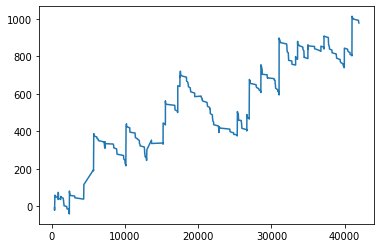

167
{'std_min': 0.000590944757382939, 'win_or_placed': 0.8054624374049968, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 5, 'n2': 7, 'odds_min': 6.909167549873465, 'odds_max': 3.448237979970457}
$$  0.062195121951218985
p/b 0.025373134328357996
% 0.15492957746478872
c 82
656.0
-656.0
82
2018-01-03 17:13:00 2018-04-13 17:38:00
                start_at          horse_name  race_id     prize  bet  odds_n  \
569  2018-01-03 17:13:00       ADJUDANT CHEF    11170 -0.358549  3.0       2   
930  2018-01-04 16:50:00        MAHER SENORA    11215  0.000000  3.0       2   
1594 2018-01-05 13:47:00            EDINGTON    13579  1.190921  1.0       0   
1603 2018-01-05 13:47:00              PHEDRE    13579  1.190921  2.0       1   
1642 2018-01-05 15:25:00       SOUTH CAPTIVA    13582  0.227237  2.0       1   
1681 2018-01-05 16:57:00             PLENARY    13585  0.000000  1.0       0   
2081 2018-01-05 11:38:00            ALBUFERA    13621 -0.358549  3.0       2   
2347 

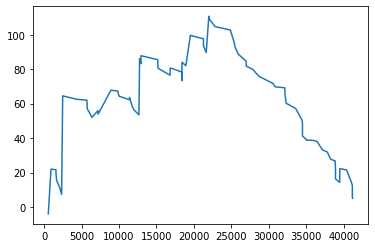

181
{'std_min': 2.8015795603262622e-06, 'win_or_placed': 0.014780925928741476, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 1, 'n2': 4, 'odds_min': 2.2583183949820342, 'odds_max': 4.694765981428129}
$$  1.636363636363636
p/b 0.6990291262135921
% 0.6923076923076923
c 44
528.0
-528.0
44
2018-01-03 17:28:00 2018-04-15 18:07:00
                start_at      horse_name  race_id     prize  bet  odds_n  \
446  2018-01-03 17:28:00     LE VALENTIN    11155 -0.202554  2.0       0   
2310 2018-01-06 13:20:00       MONTALBAN    13640 -0.444537  6.0       6   
2381 2018-01-06 16:02:00       AL MURQAB    13645 -0.131316  2.0       0   
2429 2018-01-06 17:38:00          MERAPI    13648 -0.444537  2.0       1   
3182 2018-01-08 17:21:00    MOLESNE CHOP    13729 -0.278113  6.0       6   
4376 2018-01-11 18:10:00        ZIZIOZOO    13831 -0.278113  2.0       1   
6382 2018-01-17 13:47:00  CHERIES AMOURS    14038  1.190921  2.0       0   
7136 2018-01-18 19:15:00            PI

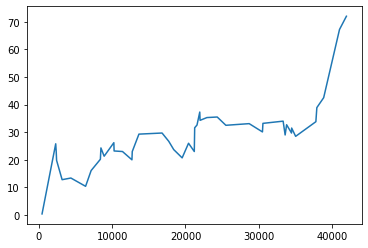

329
{'std_min': 0.0012912958379523924, 'win_or_placed': 0.1460043486364915, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 6, 'n2': 1, 'odds_min': 21.49662972494434, 'odds_max': 34.5259688699826}
$$  0.5253246753246754
p/b 0.5253246753246754
% 0.047619047619047616
c 154
462.0
-462.0
154
2018-01-03 16:40:00 2018-04-13 17:38:00
                start_at         horse_name  race_id     prize  bet  odds_n  \
453  2018-01-03 17:28:00       EARL OF FIRE    11155 -0.202554  1.0       7   
551  2018-01-03 16:40:00           BLACKSOU    11169 -0.131316  1.0       6   
555  2018-01-03 16:40:00       ITS MY STORY    11169 -0.131316  1.0      12   
571  2018-01-03 17:13:00            VOYAGER    11170 -0.358549  1.0       7   
587  2018-01-03 18:20:00              ROSNY    11172 -0.131316  1.0       7   
594  2018-01-03 18:20:00    EMERAUDE FLOWER    11172 -0.131316  1.0       8   
890  2018-01-04 15:10:00  PREMIERE GACHETTE    11212  0.227237  1.0      11   
1238 2018-01-0

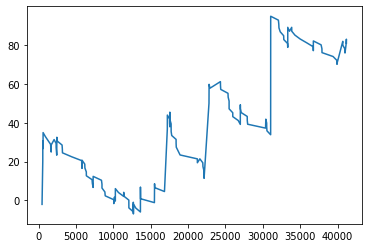

467
{'std_min': 0.0001740806237853539, 'win_or_placed': 0.9983431874043557, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 0, 'n2': 0, 'odds_min': 19.393166771917443, 'odds_max': 11.165563878546127}
$$  0.6023809523809522
p/b 0.5952941176470586
% 0.10526315789473684
c 84
336.0
-336.0
84
2018-01-03 17:28:00 2018-04-15 18:07:00
                start_at         horse_name  race_id     prize  bet  odds_n  \
448  2018-01-03 17:28:00       LANDO'S GIRL    11155 -0.202554  1.0       6   
606  2018-01-03 18:50:00       MOT DE PASSE    11173 -0.358549  1.0       3   
880  2018-01-04 15:10:00         SUBLISSIMO    11212  0.227237  2.0       0   
916  2018-01-04 16:17:00             KOMODO    11214  0.227237  1.0       2   
1241 2018-01-04 11:27:00           YARKOSKY    11238  0.000000  1.0       2   
1666 2018-01-05 16:25:00       RING MY BELL    13584  0.326999  1.0       4   
1685 2018-01-05 16:57:00           WALDENON    13585  0.000000  1.0       4   
2093 2018-01-0

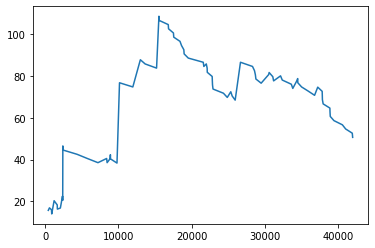

440
{'std_min': 0.0023555756073797324, 'win_or_placed': 0.9767110996421524, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 3, 'n2': 18, 'odds_min': 28.253252911752174, 'odds_max': 57.02790092014127}
$$  0.9236024844720498
p/b 0.9236024844720498
% 0.07333333333333333
c 161
241.5
-241.5
161
2018-01-02 18:42:00 2018-04-09 15:43:00
                start_at         horse_name  race_id     prize  bet  odds_n  \
252  2018-01-02 18:42:00            ZANZARI    11135 -0.278113  1.0      11   
253  2018-01-02 18:42:00        BITTERSWEAT    11135 -0.278113  1.0      12   
254  2018-01-02 18:42:00          FOOL HILL    11135 -0.278113  1.0       8   
2323 2018-01-06 13:50:00           JUGEOTTE    13641  0.227237  1.0      11   
2327 2018-01-06 13:50:00      GLAMOROUS BOY    13641  0.227237  1.0      15   
2331 2018-01-06 13:50:00       STORY BEGINS    13641  0.227237  1.0       8   
2468 2018-01-06 19:05:00            ZANZARI    13651 -0.202554  1.0      11   
2470 2018-01-06 19:

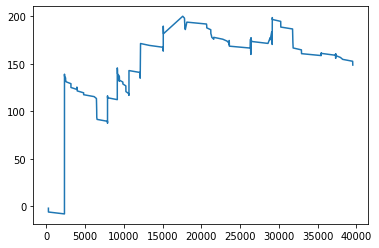

493
{'std_min': 0.001469319197432865, 'win_or_placed': 0.08510590811357212, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 0, 'n2': 4, 'odds_min': 14.189386128500065, 'odds_max': 31.916439156479633}
$$  1.7422907488986787
p/b 0.30540540540540545
% 0.06074766355140187
c 227
210.1776785714286
-210.1776785714286
227
2018-01-03 14:56:00 2018-04-13 17:38:00
                start_at         horse_name  race_id     prize  bet  odds_n  \
395  2018-01-03 14:56:00          KICK DOWN    11150  0.060810  6.0       6   
549  2018-01-03 16:40:00       LLOYDMINSTER    11169 -0.131316  4.0       3   
587  2018-01-03 18:20:00              ROSNY    11172 -0.131316  6.0       7   
606  2018-01-03 18:50:00       MOT DE PASSE    11173 -0.358549  4.0       3   
610  2018-01-03 18:50:00             MALIKA    11173 -0.358549  6.0       8   
890  2018-01-04 15:10:00  PREMIERE GACHETTE    11212  0.227237  6.0      11   
932  2018-01-04 16:50:00           CRYSALSA    11215  0.000000  6.

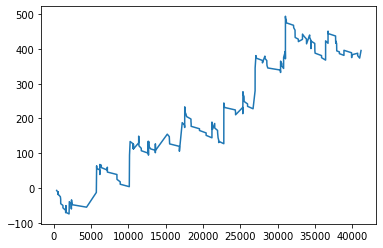

257
{'std_min': 0.0009176789595936903, 'win_or_placed': 0.13483200318934488, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 5, 'n2': 0, 'odds_min': 1.1243301650691009, 'odds_max': 46.395723638424165}
$$  0.08577712609970677
p/b 0.018807265712907896
% 0.10984540276647681
c 1364
208.78249523235968
-208.78249523235968
1364
2018-01-03 14:56:00 2018-04-15 18:07:00
               start_at       horse_name  race_id     prize  bet  odds_n  \
389 2018-01-03 14:56:00        DUKE BERE    11150  0.060810  5.0       4   
394 2018-01-03 14:56:00         MILK BAR    11150  0.060810  2.0       0   
395 2018-01-03 14:56:00        KICK DOWN    11150  0.060810  6.0       6   
397 2018-01-03 14:56:00            RAHZI    11150  0.060810  6.0       8   
398 2018-01-03 14:56:00      MACHISTADOR    11150  0.060810  6.0       5   
443 2018-01-03 17:28:00             LAVA    11155 -0.202554  2.0       1   
445 2018-01-03 17:28:00  TRUE REFLECTION    11155 -0.202554  3.0       2   
446 

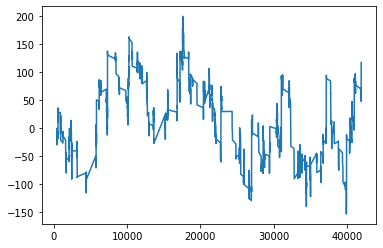

208
{'std_min': 0.0026615132158548677, 'win_or_placed': 0.3419831979819215, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 1, 'n2': 20, 'odds_min': 22.875741286521684, 'odds_max': 58.719269044818525}
$$  0.8671717171717174
p/b 0.1510114335971856
% 0.07027027027027027
c 198
198.0
-198.0
198
2018-01-06 13:50:00 2018-04-05 19:15:00
                start_at      horse_name  race_id     prize  bet  odds_n  \
2323 2018-01-06 13:50:00        JUGEOTTE    13641  0.227237  6.0      11   
2326 2018-01-06 13:50:00    PETROSINELLA    13641  0.227237  6.0       5   
2327 2018-01-06 13:50:00   GLAMOROUS BOY    13641  0.227237  6.0      15   
2331 2018-01-06 13:50:00    STORY BEGINS    13641  0.227237  6.0       8   
2466 2018-01-06 19:05:00  CHIQUIT INDIAN    13651 -0.202554  6.0       8   
2468 2018-01-06 19:05:00         ZANZARI    13651 -0.202554  6.0      11   
2469 2018-01-06 19:05:00     MY GIRL ELE    13651 -0.202554  6.0      10   
2470 2018-01-06 19:05:00    TEDDY EDWARD  

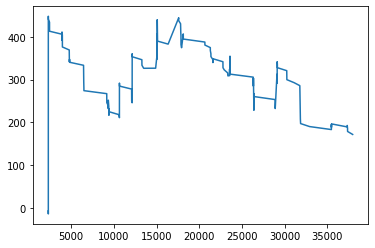

460
{'std_min': 0.002211785267777628, 'win_or_placed': 0.7230306933325962, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 2, 'n2': 11, 'odds_min': 9.47713928484984, 'odds_max': 46.42065982621905}
$$  0.6078947368421052
p/b 0.10896226415094337
% 0.06293706293706294
c 152
190.0
-190.0
152
2018-01-03 16:40:00 2018-04-12 18:57:00
               start_at        horse_name  race_id     prize  bet  odds_n  \
547 2018-01-03 16:40:00           DOWNEVA    11169 -0.131316  6.0      11   
548 2018-01-03 16:40:00          HANDCHOP    11169 -0.131316  6.0       9   
549 2018-01-03 16:40:00      LLOYDMINSTER    11169 -0.131316  4.0       3   
551 2018-01-03 16:40:00          BLACKSOU    11169 -0.131316  6.0       6   
552 2018-01-03 16:40:00     VENT DU LARGE    11169 -0.131316  6.0       7   
554 2018-01-03 16:40:00  PIERRE PRECIEUSE    11169 -0.131316  6.0       5   
555 2018-01-03 16:40:00      ITS MY STORY    11169 -0.131316  6.0      12   
556 2018-01-03 16:40:00       

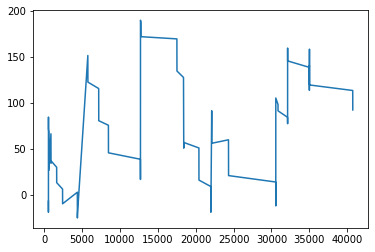

300
{'std_min': 0.0017659370286570073, 'win_or_placed': 0.9621197676379062, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 5, 'n2': 1, 'odds_min': 11.561503571473175, 'odds_max': 27.85740078390689}
$$  0.04069767441860466
p/b 0.04069767441860466
% 0.06832298136645963
c 172
172.0
-172.0
172
2018-01-03 16:40:00 2018-04-13 13:35:00
               start_at         horse_name  race_id     prize  bet  odds_n  \
549 2018-01-03 16:40:00       LLOYDMINSTER    11169 -0.131316  1.0       3   
551 2018-01-03 16:40:00           BLACKSOU    11169 -0.131316  1.0       6   
552 2018-01-03 16:40:00      VENT DU LARGE    11169 -0.131316  1.0       7   
587 2018-01-03 18:20:00              ROSNY    11172 -0.131316  1.0       7   
593 2018-01-03 18:20:00             JASPER    11172 -0.131316  1.0       1   
610 2018-01-03 18:50:00             MALIKA    11173 -0.358549  1.0       8   
883 2018-01-04 15:10:00     STREETS OF RIO    11212  0.227237  1.0       7   
890 2018-01-04 15:1

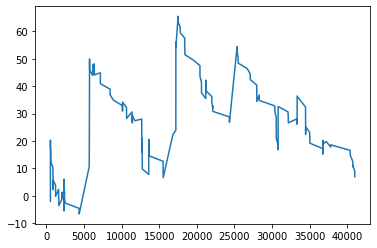

25
{'std_min': 0.001044350728387682, 'win_or_placed': 0.679090615627414, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 1, 'n2': 18, 'odds_min': 16.62727305253321, 'odds_max': 12.743429933418517}
$$  0.08574514038876889
p/b 0.08574514038876889
% 0.07674418604651163
c 463
160.23747771113634
-160.23747771113634
463
2018-01-03 14:56:00 2018-04-15 18:07:00
               start_at         horse_name  race_id     prize  bet  odds_n  \
395 2018-01-03 14:56:00          KICK DOWN    11150  0.060810  1.0       6   
442 2018-01-03 17:28:00      UKRANIAN BLUE    11155 -0.202554  1.0       8   
557 2018-01-03 16:40:00            BENJALE    11169 -0.131316  1.0       4   
558 2018-01-03 17:13:00          ISSAUROMA    11170 -0.358549  1.0       3   
560 2018-01-03 17:13:00  SPIRIT OF TEOFILO    11170 -0.358549  1.0       6   
562 2018-01-03 17:13:00      ESTARQUEFIGUE    11170 -0.358549  1.0      10   
566 2018-01-03 17:13:00  PAKISTAN TREASURE    11170 -0.358549  1.0       

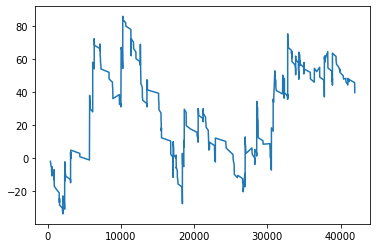

186
{'std_min': 0.002119240688411953, 'win_or_placed': 0.6672132485984187, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 10, 'n2': 15, 'odds_min': 28.74201533980305, 'odds_max': 57.94405667881685}
$$  1.7447761194029852
p/b 1.7447761194029852
% 0.046875
c 67
134.0
-134.0
67
2018-01-02 18:42:00 2018-04-13 19:10:00
                start_at        horse_name  race_id     prize  bet  odds_n  \
253  2018-01-02 18:42:00       BITTERSWEAT    11135 -0.278113  1.0      12   
2327 2018-01-06 13:50:00     GLAMOROUS BOY    13641  0.227237  1.0      15   
2468 2018-01-06 19:05:00           ZANZARI    13651 -0.202554  1.0      11   
2470 2018-01-06 19:05:00      TEDDY EDWARD    13651 -0.202554  1.0       9   
3161 2018-01-08 16:15:00        COURTOISIE    13727  0.118790  1.0       9   
3918 2018-01-10 13:15:00           ALCAZAR    13792  1.953362  1.0      11   
3942 2018-01-10 14:15:00  TRIUMPHANT JEWEL    13794  2.449254  1.0       8   
3971 2018-01-10 15:15:00        TEN FLAME

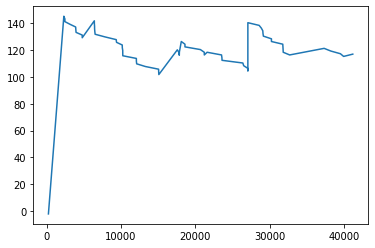

180
{'std_min': 0.0010083879645756905, 'win_or_placed': 0.5323203282585609, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 0, 'n2': 3, 'odds_min': 14.136202940507818, 'odds_max': 39.49195477982472}
$$  0.27919463087248325
p/b 0.27919463087248325
% 0.05673758865248227
c 298
129.9253494282084
-129.9253494282084
298
2018-01-03 14:56:00 2018-04-15 18:07:00
               start_at         horse_name  race_id     prize  bet  odds_n  \
395 2018-01-03 14:56:00          KICK DOWN    11150  0.060810  1.0       6   
549 2018-01-03 16:40:00       LLOYDMINSTER    11169 -0.131316  1.0       3   
587 2018-01-03 18:20:00              ROSNY    11172 -0.131316  1.0       7   
606 2018-01-03 18:50:00       MOT DE PASSE    11173 -0.358549  1.0       3   
610 2018-01-03 18:50:00             MALIKA    11173 -0.358549  1.0       8   
890 2018-01-04 15:10:00  PREMIERE GACHETTE    11212  0.227237  1.0      11   
916 2018-01-04 16:17:00             KOMODO    11214  0.227237  1.0       

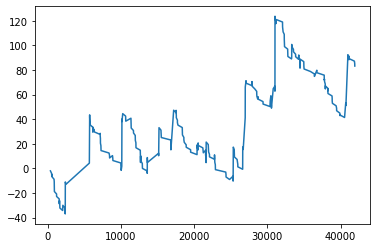

254
{'std_min': 0.0019062698564181967, 'win_or_placed': 0.05540769337256636, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 1, 'n2': 10, 'odds_min': 21.445053180831852, 'odds_max': 51.02431017763934}
$$  0.3293103448275861
p/b 0.3293103448275861
% 0.05454545454545454
c 116
92.8
-92.8
116
2018-01-03 16:40:00 2018-04-12 18:57:00
               start_at          horse_name  race_id     prize  bet  odds_n  \
547 2018-01-03 16:40:00             DOWNEVA    11169 -0.131316  1.0      11   
548 2018-01-03 16:40:00            HANDCHOP    11169 -0.131316  1.0       9   
551 2018-01-03 16:40:00            BLACKSOU    11169 -0.131316  1.0       6   
555 2018-01-03 16:40:00        ITS MY STORY    11169 -0.131316  1.0      12   
587 2018-01-03 18:20:00               ROSNY    11172 -0.131316  1.0       7   
589 2018-01-03 18:20:00          GRAND GALA    11172 -0.131316  1.0      11   
592 2018-01-03 18:20:00  ZILLION DOLLAR CUP    11172 -0.131316  1.0      10   
594 2018-01-0

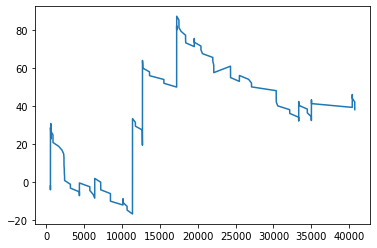

13
{'std_min': 0.0021601961867359493, 'win_or_placed': 0.16494046024188416, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 2, 'n2': 3, 'odds_min': 21.11211837869749, 'odds_max': 17.30858622291172}
$$  7.961538461538462
p/b 1.4577464788732395
% 0.3
c 13
91.0
-91.0
13
2018-01-12 19:35:00 2018-03-21 12:15:00
                 start_at        horse_name  race_id     prize  bet  odds_n  \
4813  2018-01-12 19:35:00             FLIRT    13881 -1.727705  6.0      10   
10596 2018-01-27 12:35:00     BACCHUS DANON    14462 -1.727705  6.0       6   
13281 2018-02-02 18:00:00           FAINTLY    14722 -1.678829  6.0       6   
15050 2018-02-07 12:45:00        CLOUD NINE    14898  1.953362  6.0       7   
15098 2018-02-07 14:45:00            GENTRY    14902  1.953362  5.0       4   
17874 2018-02-14 13:45:00          GRACYDAD    15182  1.953362  6.0       7   
21336 2018-02-22 19:00:00          BASATEEN    15507  2.082002  5.0       4   
22931 2018-02-26 15:40:00    EPATANT LE DU

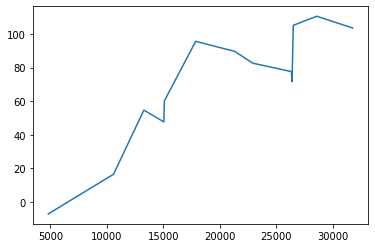

371
{'std_min': 0.0011809814799185864, 'win_or_placed': 0.7122083140250005, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 8, 'n2': 19, 'odds_min': 23.73385819617402, 'odds_max': 59.35231642016155}
$$  0.8204697986577185
p/b 0.13907849829351543
% 0.03832752613240418
c 298
75.58419958419958
-75.58419958419958
298
2018-01-02 18:42:00 2018-04-13 19:10:00
                start_at        horse_name  race_id     prize  bet  odds_n  \
250  2018-01-02 18:42:00        STALLATINA    11135 -0.278113  6.0      10   
252  2018-01-02 18:42:00           ZANZARI    11135 -0.278113  6.0      11   
253  2018-01-02 18:42:00       BITTERSWEAT    11135 -0.278113  6.0      12   
1009 2018-01-04 18:25:00         AL TAWEEL    11221  0.768024  3.0       2   
1015 2018-01-04 18:25:00        LONG WATER    11221  0.768024  6.0       6   
1020 2018-01-04 18:25:00  STRONG CHEMISTRY    11221  0.768024  6.0      13   
1036 2018-01-04 19:00:00             GREEB    11222  0.879705  6.0       9   
104

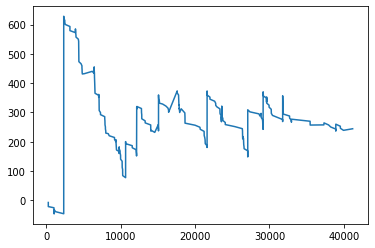

399
{'std_min': 0.0012393548588313815, 'win_or_placed': 0.014645891147044624, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 4, 'n2': 4, 'odds_min': 23.230588484406173, 'odds_max': 33.62242222884451}
$$  0.9772727272727273
p/b 0.9772727272727273
% 0.047619047619047616
c 22
66.0
-66.0
22
2018-01-08 17:21:00 2018-04-05 17:40:00
                 start_at        horse_name  race_id     prize  bet  odds_n  \
3186  2018-01-08 17:21:00      ICE MAN STAR    13729 -0.278113  1.0       5   
4402  2018-01-11 19:15:00           HERLEVA    13833 -0.636657  1.0       9   
5809  2018-01-15 15:43:00  GREY MAGIC NIGHT    13988 -0.063929  1.0      10   
7190  2018-01-18 21:15:00        SNOW DREAM    14116 -0.636657  1.0       9   
7293  2018-01-19 16:27:00      CREACH LIGHT    14127  0.326999  1.0      10   
11382 2018-01-29 14:35:00           HONIARA    14547  0.000000  1.0       7   
12667 2018-02-01 13:29:00    DAUPHINE DOREE    14658 -0.202554  1.0       9   
13619 2018-02-

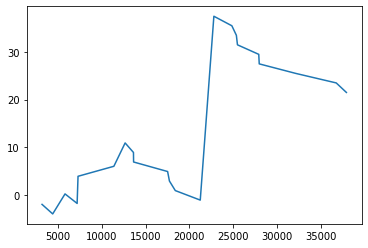

148
{'std_min': 0.0010405269645153404, 'win_or_placed': 0.8074185272001151, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 0, 'n2': 7, 'odds_min': 26.51455913163496, 'odds_max': 58.15006527278167}
$$  0.5257383966244725
p/b 0.5257383966244725
% 0.039473684210526314
c 237
64.71351835273055
-64.71351835273055
237
2018-01-03 14:56:00 2018-04-15 18:07:00
               start_at         horse_name  race_id     prize  bet  odds_n  \
402 2018-01-03 14:56:00        NOMAD ARROW    11150  0.060810  1.0      12   
444 2018-01-03 17:28:00          GARAJONAY    11155 -0.202554  1.0      10   
449 2018-01-03 17:28:00         CORRENTOSO    11155 -0.202554  1.0      12   
453 2018-01-03 17:28:00       EARL OF FIRE    11155 -0.202554  1.0       7   
571 2018-01-03 17:13:00            VOYAGER    11170 -0.358549  1.0       7   
589 2018-01-03 18:20:00         GRAND GALA    11172 -0.131316  1.0      11   
594 2018-01-03 18:20:00    EMERAUDE FLOWER    11172 -0.131316  1.0       8 

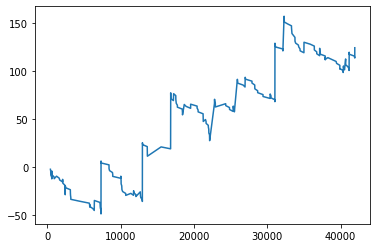

417
{'std_min': 0.0007066450858407616, 'win_or_placed': 0.04762076084981849, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 4, 'n2': 7, 'odds_min': 27.52618458776461, 'odds_max': 45.46405620708029}
$$  0.5330578512396693
p/b 0.5330578512396693
% 0.04310344827586207
c 121
60.5
-60.5
121
2018-01-03 17:13:00 2018-04-15 18:07:00
                start_at        horse_name  race_id     prize  bet  odds_n  \
444  2018-01-03 17:28:00         GARAJONAY    11155 -0.202554  1.0      10   
453  2018-01-03 17:28:00      EARL OF FIRE    11155 -0.202554  1.0       7   
571  2018-01-03 17:13:00           VOYAGER    11170 -0.358549  1.0       7   
589  2018-01-03 18:20:00        GRAND GALA    11172 -0.131316  1.0      11   
594  2018-01-03 18:20:00   EMERAUDE FLOWER    11172 -0.131316  1.0       8   
609  2018-01-03 18:50:00  NIGHT OF MYSTERY    11173 -0.358549  1.0      12   
917  2018-01-04 16:17:00   SPIRIT OF NAYEF    11214  0.227237  1.0      12   
1235 2018-01-04 11:27:0

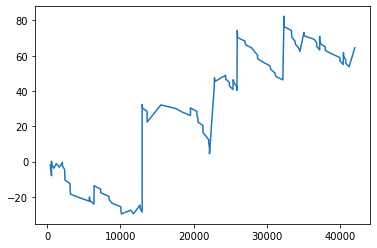

22
{'std_min': 0.00019767729223645086, 'win_or_placed': 0.3654961062634104, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 7, 'n2': 7, 'odds_min': 28.323705583063642, 'odds_max': 44.99995492620603}
$$  6.589999999999999
p/b 1.1909638554216866
% 0.15384615384615385
c 30
60.0
-60.0
30
2018-01-06 19:15:00 2018-04-03 16:50:00
                 start_at         horse_name  race_id     prize  bet  odds_n  \
2532  2018-01-06 19:15:00  SEEKING THE GHOST    13657 -1.413855  6.0       7   
4345  2018-01-11 18:25:00            YATTWEE    13829  2.389686  6.0      12   
6476  2018-01-17 13:15:00      STAR SUPERIOR    14050  1.953362  6.0       8   
6529  2018-01-17 15:15:00          PLAY WISE    14054  2.449254  6.0      10   
7077  2018-01-18 18:25:00            DANZENO    14108  2.177924  6.0      11   
9152  2018-01-23 17:25:00       OLD FIREHAND    14314 -1.727705  6.0      10   
9171  2018-01-23 17:55:00             MAROLO    14315 -1.678829  6.0      13   
9345  2018-01-24 

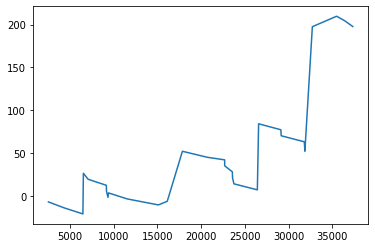

94
{'std_min': 0.0024751214122474066, 'win_or_placed': 0.30737611711421614, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 5, 'n2': 7, 'odds_min': 0.748341738814048, 'odds_max': 8.657165795333443}
$$  -0.13717948717948722
p/b -0.12022471910112363
% 0.18181818181818182
c 78
58.5
-58.5
78
2018-01-06 19:05:00 2018-04-12 17:13:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
2461 2018-01-06 19:05:00      GOLDEN RASH    13651 -0.202554  2.0       0   
3156 2018-01-08 16:15:00  VAL DE LA GESSE    13727  0.118790  1.0       1   
3974 2018-01-10 15:15:00    WINNING FAITH    13796  2.449254  1.0       3   
4804 2018-01-12 19:02:00          KEPHEUS    13880 -1.678829  1.0       3   
4819 2018-01-12 19:35:00           MAROLO    13881 -1.727705  1.0       8   
4829 2018-01-12 20:08:00          INIESTA    13882 -1.500499  1.0       2   
5158 2018-01-13 20:15:00        MAXIMIANO    13917 -1.499876  1.0       2   
6464 2018-01-17 12:45:00   AMAZING AL

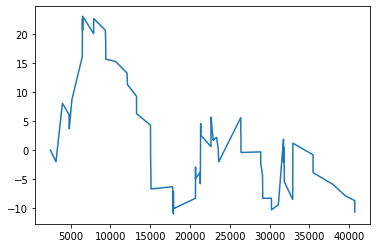

224
{'std_min': 0.0023515939129390867, 'win_or_placed': 0.8145851222967279, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 2, 'n2': 6, 'odds_min': 17.654175286328087, 'odds_max': 34.39480485510169}
$$  0.7684210526315787
p/b 0.1303571428571428
% 0.05555555555555555
c 19
57.0
-57.0
19
2018-01-03 16:40:00 2018-03-29 15:55:00
                 start_at     horse_name  race_id     prize  bet  odds_n  \
549   2018-01-03 16:40:00   LLOYDMINSTER    11169 -0.131316  4.0       3   
551   2018-01-03 16:40:00       BLACKSOU    11169 -0.131316  6.0       6   
555   2018-01-03 16:40:00   ITS MY STORY    11169 -0.131316  6.0      12   
1641  2018-01-05 15:25:00           UCEL    13582  0.227237  6.0       7   
8474  2018-01-22 16:57:00       DIARISSA    14256  0.326999  6.0       8   
8475  2018-01-22 16:57:00           RYOS    14256  0.326999  6.0       9   
8476  2018-01-22 16:57:00    PAPA WINNER    14256  0.326999  6.0       7   
12698 2018-02-01 14:37:00  LA MICHODIERE 

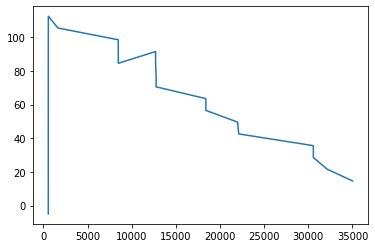

246
{'std_min': 0.002342914277387559, 'win_or_placed': 0.4301808576390542, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 3, 'n2': 4, 'odds_min': 29.111259835116503, 'odds_max': 10.516531173785411}
$$  0.1257731958762888
p/b 0.1257731958762888
% 0.10227272727272728
c 97
51.733333333333334
-51.733333333333334
97
2018-01-06 19:15:00 2018-04-12 17:13:00
                start_at      horse_name  race_id     prize  bet  odds_n  \
2541 2018-01-06 19:15:00  STRONG CHARLES    13657 -1.413855  1.0       4   
3152 2018-01-08 16:15:00          SEISME    13727  0.118790  1.0       8   
3929 2018-01-10 13:15:00           BINGO    13792  1.953362  1.0       6   
3976 2018-01-10 15:15:00       THE SYLPH    13796  2.449254  1.0       7   
4783 2018-01-12 18:00:00          SARITA    13878 -1.727705  1.0       9   
4813 2018-01-12 19:35:00           FLIRT    13881 -1.727705  1.0      10   
4824 2018-01-12 20:08:00      WHISHAWIZZ    13882 -1.500499  1.0       3   
5159 2018-01-13 20:1

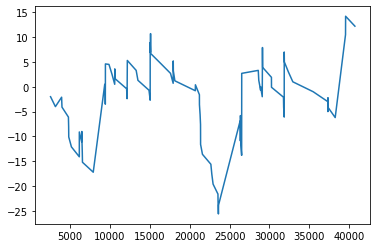

124
{'std_min': 0.00019995276705535571, 'win_or_placed': 0.10407876636568494, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 0, 'n2': 14, 'odds_min': 28.919271776030225, 'odds_max': 44.4742844478206}
$$  0.3573446327683615
p/b 0.3573446327683615
% 0.03812316715542522
c 354
44.7966992439609
-44.7966992439609
354
2018-01-03 14:56:00 2018-04-15 18:07:00
               start_at        horse_name  race_id     prize  bet  odds_n  \
400 2018-01-03 14:56:00       GREY MIRAGE    11150  0.060810  1.0      11   
444 2018-01-03 17:28:00         GARAJONAY    11155 -0.202554  1.0      10   
447 2018-01-03 17:28:00    EIGHTEEN POEMS    11155 -0.202554  1.0       9   
453 2018-01-03 17:28:00      EARL OF FIRE    11155 -0.202554  1.0       7   
548 2018-01-03 16:40:00          HANDCHOP    11169 -0.131316  1.0       9   
571 2018-01-03 17:13:00           VOYAGER    11170 -0.358549  1.0       7   
589 2018-01-03 18:20:00        GRAND GALA    11172 -0.131316  1.0      11   
594 2

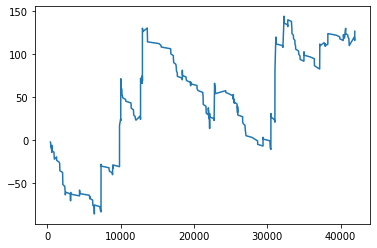

449
{'std_min': 0.0025067825139278416, 'win_or_placed': 0.8459838734615374, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 2, 'n2': 17, 'odds_min': 12.309645184607724, 'odds_max': 21.461061033279567}
$$  1.0192307692307692
p/b 1.0192307692307692
% 0.08333333333333333
c 26
39.0
-39.0
26
2018-02-01 16:50:00 2018-03-29 15:55:00
                 start_at         horse_name  race_id     prize  bet  odds_n  \
12757 2018-02-01 16:50:00            BROGLIE    14664  0.000000  1.0       8   
12758 2018-02-01 16:50:00  MAIDSTONE MAJESTY    14664  0.000000  1.0      11   
12761 2018-02-01 16:50:00    SANTA VALENTINA    14664  0.000000  1.0      10   
12764 2018-02-01 16:50:00              BUTOT    14664  0.000000  1.0       9   
18386 2018-02-15 17:40:00            VIXENTA    15238 -0.278113  1.0       6   
18388 2018-02-15 17:40:00        EVREST BERE    15238 -0.278113  1.0      11   
18390 2018-02-15 17:40:00        NIGHT SHIFT    15238 -0.278113  1.0       5   
18391 2

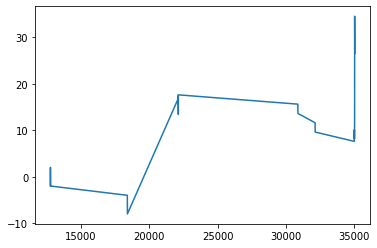

367
{'std_min': 0.0007982896205976949, 'win_or_placed': 0.2267052627132849, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 5, 'n2': 1, 'odds_min': 19.215534506307584, 'odds_max': 35.883966145705116}
$$  0.34592274678111584
p/b 0.34592274678111584
% 0.04954954954954955
c 233
35.791991941576434
-35.791991941576434
233
2018-01-03 16:40:00 2018-04-15 18:07:00
                start_at          horse_name  race_id     prize  bet  odds_n  \
453  2018-01-03 17:28:00        EARL OF FIRE    11155 -0.202554  1.0       7   
549  2018-01-03 16:40:00        LLOYDMINSTER    11169 -0.131316  1.0       3   
551  2018-01-03 16:40:00            BLACKSOU    11169 -0.131316  1.0       6   
587  2018-01-03 18:20:00               ROSNY    11172 -0.131316  1.0       7   
890  2018-01-04 15:10:00   PREMIERE GACHETTE    11212  0.227237  1.0      11   
926  2018-01-04 16:17:00        PAMPA BRIGHT    11214  0.227237  1.0       9   
1238 2018-01-04 11:27:00             ELUSIVA    11238  0

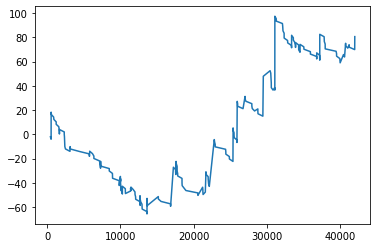

244
{'std_min': 0.001752187153900069, 'win_or_placed': 0.2506214289669589, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 3, 'n2': 1, 'odds_min': 5.329552119000842, 'odds_max': 5.914674595572459}
$$  0.7307692307692304
p/b 0.2087912087912087
% 0.13043478260869565
c 26
34.666666666666664
-34.666666666666664
26
2018-01-06 19:05:00 2018-04-03 16:50:00
                 start_at         horse_name  race_id     prize  bet  odds_n  \
2462  2018-01-06 19:05:00           OPERATOR    13651 -0.202554  2.0       1   
4820  2018-01-12 19:35:00        PEPPY MUSIC    13881 -1.727705  6.0       6   
6448  2018-01-17 11:00:00        SPEED FORCE    14045 -0.579415  2.0       0   
6452  2018-01-17 12:15:00          LOOK ERAS    14048  1.953362  3.0       2   
9343  2018-01-24 12:45:00        BORN DRAGON    14333  1.953362  6.0       5   
9383  2018-01-24 14:20:00  BEAUTY CONNECTION    14336  1.953362  4.0       3   
9416  2018-01-24 15:55:00       JADE FORTUNE    14339  2.449254  6.0  

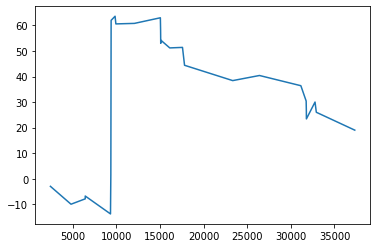

74
{'std_min': 0.0025344521575890976, 'win_or_placed': 0.029100014201105757, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 10, 'n2': 7, 'odds_min': 20.818692328036427, 'odds_max': 5.4531439219445685}
$$  0.4304347826086956
p/b 0.4304347826086956
% 0.09523809523809523
c 23
34.5
-34.5
23
2018-02-01 16:50:00 2018-03-29 15:55:00
                 start_at     horse_name  race_id     prize  bet  odds_n  \
12752 2018-02-01 16:50:00  MONSIEUR ENZO    14664  0.000000  1.0       1   
12753 2018-02-01 16:50:00     TRAWANGANE    14664  0.000000  1.0       3   
12754 2018-02-01 16:50:00          RISKA    14664  0.000000  1.0       4   
12763 2018-02-01 16:50:00         TRAIZE    14664  0.000000  1.0       6   
18384 2018-02-15 17:40:00        SIVINSK    15238 -0.278113  1.0       7   
18386 2018-02-15 17:40:00        VIXENTA    15238 -0.278113  1.0       6   
18388 2018-02-15 17:40:00    EVREST BERE    15238 -0.278113  1.0      11   
18390 2018-02-15 17:40:00    NIGHT SHI

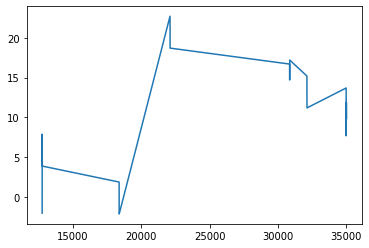

95
{'std_min': 0.0020075591414768328, 'win_or_placed': 0.22265793276038898, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 2, 'n2': 0, 'odds_min': 26.91831219644149, 'odds_max': 19.93145325761861}
$$  -0.4093749999999998
p/b -0.07197802197802194
% 0.06666666666666667
c 32
32.0
-32.0
32
2018-01-08 16:15:00 2018-04-13 16:37:00
                 start_at      horse_name  race_id     prize  bet  odds_n  \
3158  2018-01-08 16:15:00     LA PRESABIA    13727  0.118790  6.0       7   
6150  2018-01-16 15:10:00         CASHBAG    14018  0.000000  6.0       8   
6539  2018-01-17 15:50:00   BLAZE STAMINA    14055  2.449254  6.0       6   
7039  2018-01-18 16:05:00  DIRECT MESSAGE    14104  1.167183  6.0      12   
7874  2018-01-20 17:04:00       FULL PELT    14188 -1.141981  6.0       8   
9173  2018-01-23 17:55:00           REVIE    14315 -1.678829  6.0      10   
10245 2018-01-26 16:47:00           AREIA    14432  0.000000  6.0       9   
10252 2018-01-26 16:47:00        YARKO

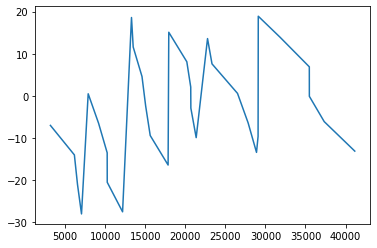

363
{'std_min': 0.0023931029019144344, 'win_or_placed': 0.23260187745708433, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 3, 'n2': 13, 'odds_min': 24.106358847379745, 'odds_max': 28.301584192537916}
$$  0.19836065573770492
p/b 0.19836065573770492
% 0.08928571428571429
c 61
30.5
-30.5
61
2018-01-02 18:42:00 2018-04-09 14:38:00
                start_at        horse_name  race_id     prize  bet  odds_n  \
250  2018-01-02 18:42:00        STALLATINA    11135 -0.278113  1.0      10   
2466 2018-01-06 19:05:00    CHIQUIT INDIAN    13651 -0.202554  1.0       8   
3152 2018-01-08 16:15:00            SEISME    13727  0.118790  1.0       8   
3919 2018-01-10 13:15:00     LOVE CHUNGHWA    13792  1.953362  1.0      10   
3924 2018-01-10 13:15:00       COUR VALANT    13792  1.953362  1.0       7   
4776 2018-01-12 18:00:00  CHEERS ALL ROUND    13878 -1.727705  1.0      10   
4779 2018-01-12 18:00:00       PEARL QUEEN    13878 -1.727705  1.0       8   
4792 2018-01-12 18:33:00   

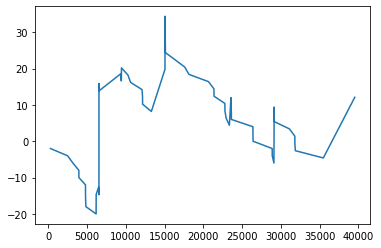

444
{'std_min': 0.002254166954429284, 'win_or_placed': 0.8495437967618942, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 7, 'n2': 8, 'odds_min': 23.35121861897646, 'odds_max': 5.960584328073997}
$$  0.13655172413793099
p/b 0.13288590604026843
% 0.11538461538461539
c 145
29.414699035583627
-29.414699035583627
145
2018-01-02 18:42:00 2018-04-13 16:37:00
                start_at         horse_name  race_id     prize  bet  odds_n  \
247  2018-01-02 18:42:00        GRAND BANKS    11135 -0.278113  1.0       9   
2464 2018-01-06 19:05:00             SOWGAY    13651 -0.202554  1.0       5   
2469 2018-01-06 19:05:00        MY GIRL ELE    13651 -0.202554  1.0      10   
2537 2018-01-06 19:15:00             ILIGHT    13657 -1.413855  1.0       5   
3157 2018-01-08 16:15:00            KENRISK    13727  0.118790  1.0       4   
3940 2018-01-10 13:45:00         VARA PEARL    13793  1.953362  1.0      11   
3941 2018-01-10 13:45:00  GOOD CHOICE AHEAD    13793  1.953362  1.0      

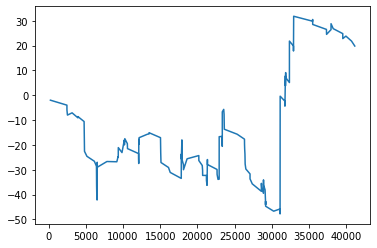

118
{'std_min': 0.00017980190103627437, 'win_or_placed': 0.18975361652607808, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 10, 'n2': 10, 'odds_min': 20.536582174419713, 'odds_max': 40.15421782622013}
$$  1.0833333333333333
p/b 0.18505338078291814
% 0.02127659574468085
c 48
29.338677354709418
-29.338677354709418
48
2018-01-04 19:00:00 2018-04-12 17:13:00
                start_at         horse_name  race_id     prize  bet  odds_n  \
1036 2018-01-04 19:00:00              GREEB    11222  0.879705  6.0       9   
2470 2018-01-06 19:05:00       TEDDY EDWARD    13651 -0.202554  6.0       9   
4336 2018-01-11 18:25:00           TASHWEEQ    13829  2.389686  6.0      11   
4776 2018-01-12 18:00:00   CHEERS ALL ROUND    13878 -1.727705  6.0      10   
4794 2018-01-12 18:33:00       WILSONS RUBY    13879 -1.727705  6.0       6   
4798 2018-01-12 19:02:00        MANDELSAMEN    13880 -1.678829  6.0       6   
5124 2018-01-13 18:15:00         JUAN DIEGO    13913 -2.016408  6.0   

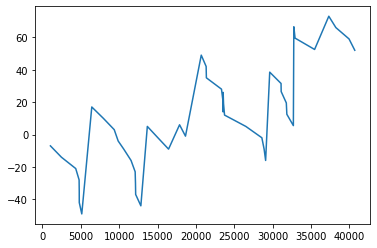

96
{'std_min': 0.0027858213278452275, 'win_or_placed': 0.42694341039832007, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 3, 'n2': 10, 'odds_min': 11.649588106694477, 'odds_max': 9.623612178393845}
$$  0.3863636363636367
p/b 0.07623318385650231
% 0.1
c 44
29.333333333333332
-29.333333333333332
44
2018-01-06 19:05:00 2018-04-05 19:15:00
                 start_at         horse_name  race_id     prize  bet  odds_n  \
2459  2018-01-06 19:05:00  NINIAN DES AIGLES    13651 -0.202554  5.0       4   
3926  2018-01-10 13:15:00   CONFUCIUS SPIRIT    13792  1.953362  5.0       4   
4778  2018-01-12 18:00:00          TRIBESMAN    13878 -1.727705  3.0       2   
6446  2018-01-17 11:00:00       BEAUFORT LAD    14045 -0.579415  6.0       5   
6473  2018-01-17 12:45:00       SPICY DOUBLE    14049  1.594792  5.0       4   
7896  2018-01-20 18:04:00     RISE AND SHINE    14190 -2.005771  4.0       3   
9339  2018-01-24 12:45:00   HAPPY HAPPY STAR    14333  1.953362  6.0       7   
10

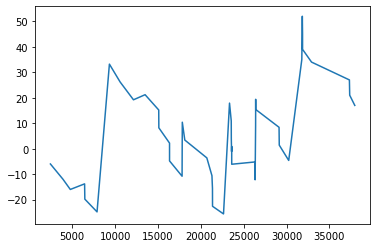

216
{'std_min': 0.0014968638508126842, 'win_or_placed': 0.3931224152234172, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 3, 'n2': 8, 'odds_min': 1.6058886062195434, 'odds_max': 10.897343678741299}
$$  -0.15454545454545454
p/b -0.15454545454545454
% 0.16470588235294117
c 297
28.798937233172857
-28.798937233172857
297
2018-01-03 14:56:00 2018-04-13 17:38:00
               start_at        horse_name  race_id     prize  bet  odds_n  \
389 2018-01-03 14:56:00         DUKE BERE    11150  0.060810  1.0       4   
391 2018-01-03 14:56:00        LIFE PRIDE    11150  0.060810  1.0       3   
392 2018-01-03 14:56:00        ELIMINATOR    11150  0.060810  1.0       2   
394 2018-01-03 14:56:00          MILK BAR    11150  0.060810  1.0       0   
545 2018-01-03 16:40:00        VERTI CHOP    11169 -0.131316  1.0       1   
554 2018-01-03 16:40:00  PIERRE PRECIEUSE    11169 -0.131316  1.0       5   
559 2018-01-03 17:13:00          CAMPIONE    11170 -0.358549  1.0       1  

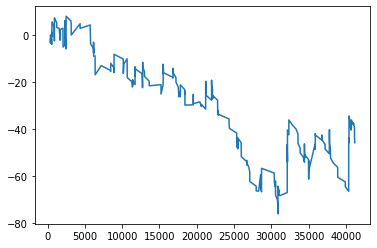

217
{'std_min': 0.0004385259038064558, 'win_or_placed': 0.19333464076691403, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 2, 'n2': 6, 'odds_min': 26.703346241574216, 'odds_max': 59.345306233787454}
$$  0.25
p/b 0.041666666666666664
% 0.029585798816568046
c 174
27.858267716535433
-27.858267716535433
174
2018-01-03 14:56:00 2018-04-15 18:07:00
                start_at         horse_name  race_id     prize  bet  odds_n  \
402  2018-01-03 14:56:00        NOMAD ARROW    11150  0.060810  6.0      12   
444  2018-01-03 17:28:00          GARAJONAY    11155 -0.202554  6.0      10   
449  2018-01-03 17:28:00         CORRENTOSO    11155 -0.202554  6.0      12   
453  2018-01-03 17:28:00       EARL OF FIRE    11155 -0.202554  6.0       7   
571  2018-01-03 17:13:00            VOYAGER    11170 -0.358549  6.0       7   
589  2018-01-03 18:20:00         GRAND GALA    11172 -0.131316  6.0      11   
594  2018-01-03 18:20:00    EMERAUDE FLOWER    11172 -0.131316  6.0       8

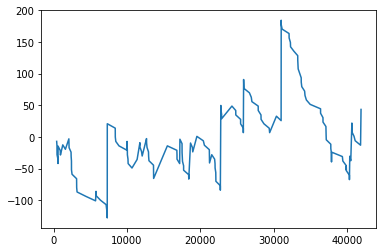

483
{'std_min': 0.0016043706286314977, 'win_or_placed': 0.779349272276852, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 0, 'n2': 4, 'odds_min': 25.22501134372229, 'odds_max': 5.9071706982355625}
$$  -0.19399538106235562
p/b -0.19399538106235562
% 0.08793969849246232
c 433
27.24899929847729
-27.24899929847729
433
2018-01-03 14:56:00 2018-04-13 17:38:00
               start_at         horse_name  race_id     prize  bet  odds_n  \
395 2018-01-03 14:56:00          KICK DOWN    11150  0.060810  1.0       6   
397 2018-01-03 14:56:00              RAHZI    11150  0.060810  1.0       8   
398 2018-01-03 14:56:00        MACHISTADOR    11150  0.060810  1.0       5   
545 2018-01-03 16:40:00         VERTI CHOP    11169 -0.131316  1.0       1   
549 2018-01-03 16:40:00       LLOYDMINSTER    11169 -0.131316  1.0       3   
550 2018-01-03 16:40:00          CAP ROCAT    11169 -0.131316  1.0       2   
552 2018-01-03 16:40:00      VENT DU LARGE    11169 -0.131316  1.0      

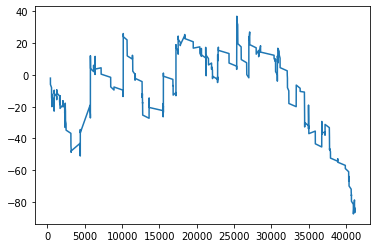

57
{'std_min': 0.0024960150115305823, 'win_or_placed': 0.49030534654873725, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 10, 'n2': 10, 'odds_min': 8.651954919944819, 'odds_max': 14.485117204594442}
$$  6.781249999999999
p/b 1.2055555555555555
% 0.14285714285714285
c 16
26.666666666666668
-26.666666666666668
16
2018-01-17 11:00:00 2018-04-03 19:10:00
                 start_at       horse_name  race_id     prize  bet  odds_n  \
6446  2018-01-17 11:00:00     BEAUFORT LAD    14045 -0.579415  6.0       5   
9373  2018-01-24 13:45:00     RAINBOW GOLD    14335  1.594792  6.0       6   
9409  2018-01-24 15:20:00        SUPER MAN    14338  2.449254  6.0       6   
13496 2018-02-03 13:09:00           SEISME    14743 -0.278113  6.0       5   
15087 2018-02-07 14:15:00      BUOYANT BOY    14901  1.953362  6.0      10   
17943 2018-02-14 13:27:00           GOJICI    15189 -0.444537  5.0       4   
20659 2018-02-21 13:45:00   KING BOUNTIFUL    15449  1.953362  6.0       7   
213

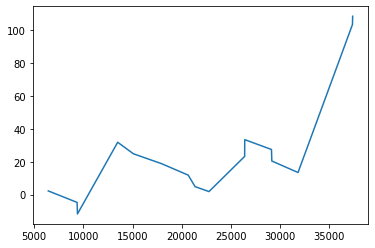

378
{'std_min': 0.0012802195559547705, 'win_or_placed': 0.7014763244005945, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 1, 'n2': 5, 'odds_min': 14.182762249828611, 'odds_max': 33.5828742929753}
$$  0.6749206349206348
p/b 0.11726420297848868
% 0.05351170568561873
c 315
25.83911570114571
-25.83911570114571
315
2018-01-03 14:56:00 2018-04-13 17:38:00
               start_at         horse_name  race_id     prize  bet  odds_n  \
395 2018-01-03 14:56:00          KICK DOWN    11150  0.060810  6.0       6   
453 2018-01-03 17:28:00       EARL OF FIRE    11155 -0.202554  6.0       7   
549 2018-01-03 16:40:00       LLOYDMINSTER    11169 -0.131316  4.0       3   
551 2018-01-03 16:40:00           BLACKSOU    11169 -0.131316  6.0       6   
566 2018-01-03 17:13:00  PAKISTAN TREASURE    11170 -0.358549  6.0       9   
587 2018-01-03 18:20:00              ROSNY    11172 -0.131316  6.0       7   
610 2018-01-03 18:50:00             MALIKA    11173 -0.358549  6.0       8 

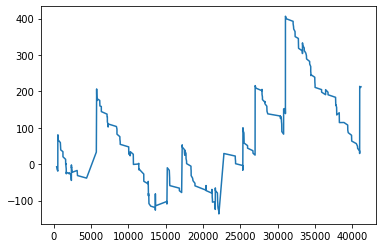

421
{'std_min': 0.002237026045655883, 'win_or_placed': 0.5358005087000497, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 5, 'n2': 1, 'odds_min': 2.3620416832097937, 'odds_max': 50.74869658027073}
$$  -0.18849557522123903
p/b -0.04176470588235296
% 0.0970873786407767
c 113
25.61501300631735
-25.61501300631735
113
2018-01-03 16:40:00 2018-04-12 18:57:00
               start_at       horse_name  race_id     prize  bet  odds_n  \
545 2018-01-03 16:40:00       VERTI CHOP    11169 -0.131316  2.0       1   
549 2018-01-03 16:40:00     LLOYDMINSTER    11169 -0.131316  4.0       3   
550 2018-01-03 16:40:00        CAP ROCAT    11169 -0.131316  3.0       2   
551 2018-01-03 16:40:00         BLACKSOU    11169 -0.131316  6.0       6   
552 2018-01-03 16:40:00    VENT DU LARGE    11169 -0.131316  6.0       7   
601 2018-01-03 18:50:00          LEAPING    11173 -0.358549  6.0       5   
602 2018-01-03 18:50:00           VOISIN    11173 -0.358549  2.0       1   
603 2018-01

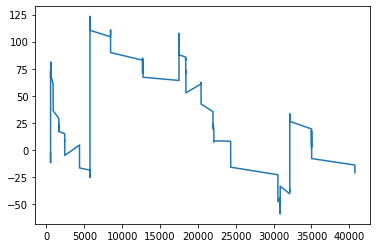

In [1056]:
#res_gp.x_iters
indices = [index for index, value in sorted(enumerate(res_gp.func_vals), reverse=False, key=lambda x: x[1])][:40]
#res_gp.func_vals
#res_gp.x
#res_gp.fun

from matplotlib import pyplot as plt

for indice in indices:
    print(indice)
    print(ff(res_gp.x_iters[indice]))
    
    g['stash'] = g['profit'].cumsum()
    print(len(g))
    print(g['start_at'].min(), g['start_at'].max())
    print(g[['start_at', 'horse_name', 'race_id', 'prize', 'bet', 'odds_n', 'sub_category', 'final_odds', 'winner_dividend', 'placed_dividend', 'position', 'bet', 'profit', 'stash']].head(10))
    g['stash'].plot()
    plt.show()

{'std_min': 0.00046533521175744073, 'win_or_placed': 0.782485432655757, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'INCONNU', 'n1': 5, 'n2': 0, 'odds_min': 22.647943321888107, 'odds_max': 51.39578561782152}
$$  -2.4417449664429527
p/b -0.41286881525192914
% 0.02194787379972565
c 745
2.230538922155689
INCONNU [0.00046533521175744073, 0.782485432655757, 1, 1, 'INCONNU', 5, 0, 22.647943321888107, 51.39578561782152] -2.230538922155689
races 745
2018-01-01 11:12:00 2018-04-15 13:53:00
               start_at        horse_name  race_id     prize  bet  odds_n  \
16  2018-01-02 13:12:00     FERIA D'ANAMA    11117  0.697484  6.0       6   
17  2018-01-02 13:12:00   FIONA DE BAILLY    11117  0.697484  6.0       9   
19  2018-01-02 13:12:00      FILIA PIERJI    11117  0.697484  6.0       8   
50  2018-01-02 14:20:00          ENNEIGEE    11119  0.661355  6.0      12   
94  2018-01-02 15:55:00       EVITA BELLI    11122  0.982707  6.0      12   
483 2018-01-03 13:25:00   EL FUEGO DE BEZ    111

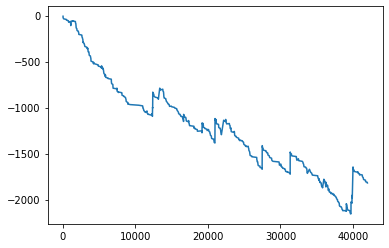

{'std_min': 0.00046533521175744073, 'win_or_placed': 0.782485432655757, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'AUTOSTART', 'n1': 5, 'n2': 0, 'odds_min': 22.647943321888107, 'odds_max': 51.39578561782152}
$$  -2.541814595660749
p/b -0.43967929034459224
% 0.03680981595092025
c 507
7.52970297029703
AUTOSTART [0.00046533521175744073, 0.782485432655757, 1, 1, 'AUTOSTART', 5, 0, 22.647943321888107, 51.39578561782152] -7.52970297029703
races 507
2018-01-01 14:38:00 2018-04-14 18:37:00
               start_at         horse_name  race_id     prize  bet  odds_n  \
105 2018-01-02 16:25:00  DAPHNE CLEMAXELLE    11123  0.732596  6.0       8   
285 2018-01-02 16:55:00       DERBY DE NAY    11139 -1.500499  6.0       5   
299 2018-01-02 17:25:00  CLASSELLA THICEMA    11140 -1.500499  6.0       7   
306 2018-01-02 17:25:00   BELLE MAGNIFIQUE    11140 -1.500499  6.0       9   
325 2018-01-02 18:28:00   DOUGLAS DU HAUTY    11142 -1.500499  5.0       4   
327 2018-01-02 18:28:00             BOG

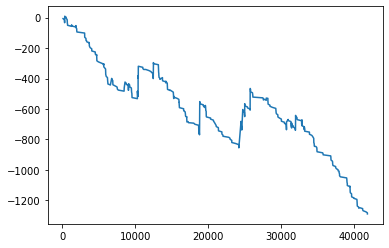

{'std_min': 0.00046533521175744073, 'win_or_placed': 0.782485432655757, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 5, 'n2': 0, 'odds_min': 22.647943321888107, 'odds_max': 51.39578561782152}
$$  3.9245454545454543
p/b 0.6555808656036446
% 0.06280193236714976
c 220
142.35294117647058
HANDICAP_DIVISE [0.00046533521175744073, 0.782485432655757, 1, 1, 'HANDICAP_DIVISE', 5, 0, 22.647943321888107, 51.39578561782152] -142.35294117647058
races 220
2018-01-03 16:40:00 2018-04-15 18:07:00
                start_at         horse_name  race_id     prize  bet  odds_n  \
449  2018-01-03 17:28:00         CORRENTOSO    11155 -0.202554  6.0      12   
453  2018-01-03 17:28:00       EARL OF FIRE    11155 -0.202554  6.0       7   
551  2018-01-03 16:40:00           BLACKSOU    11169 -0.131316  6.0       6   
589  2018-01-03 18:20:00         GRAND GALA    11172 -0.131316  6.0      11   
886  2018-01-04 15:10:00  NOTANOTHERHOLIDAY    11212  0.227237  6.0      12   
890  2018-01-

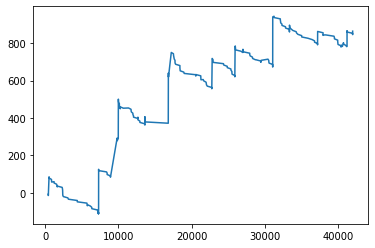

{'std_min': 0.00046533521175744073, 'win_or_placed': 0.782485432655757, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP', 'n1': 5, 'n2': 0, 'odds_min': 22.647943321888107, 'odds_max': 51.39578561782152}
$$  -1.9484732824427482
p/b -0.34727891156462587
% 0.03968253968253968
c 262
8.733333333333333
HANDICAP [0.00046533521175744073, 0.782485432655757, 1, 1, 'HANDICAP', 5, 0, 22.647943321888107, 51.39578561782152] -8.733333333333333
races 262
2018-01-01 19:04:00 2018-04-14 11:40:00
                start_at         horse_name  race_id     prize  bet  odds_n  \
254  2018-01-02 18:42:00          FOOL HILL    11135 -0.278113  6.0       8   
1017 2018-01-04 18:25:00       SECRET TRADE    11221  0.768024  6.0      11   
1030 2018-01-04 19:00:00      SHARP DEFENCE    11222  0.879705  6.0      15   
1479 2018-01-01 19:04:00      NOBLE GALILEO    13565 -1.308393  6.0       6   
1480 2018-01-01 19:04:00               ADAO    13565 -1.308393  6.0       7   
2323 2018-01-06 13:50:00         

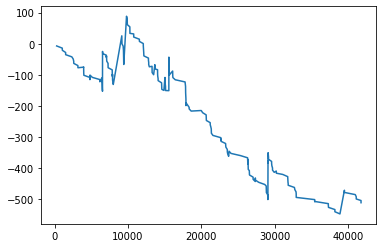

{'std_min': 0.00046533521175744073, 'win_or_placed': 0.782485432655757, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.647943321888107, 'odds_max': 51.39578561782152}
$$  -1.4777251184834121
p/b -0.2528791565287915
% 0.03940886699507389
c 211
3.403225806451613
COURSE_A_CONDITIONS [0.00046533521175744073, 0.782485432655757, 1, 1, 'COURSE_A_CONDITIONS', 5, 0, 22.647943321888107, 51.39578561782152] -3.403225806451613
races 211
2018-01-01 15:32:00 2018-04-14 13:50:00
               start_at          horse_name  race_id     prize  bet  odds_n  \
125 2018-01-02 14:05:00      CIRANO DE PAIL    11126  0.585794  6.0       5   
168 2018-01-02 15:40:00  ATLANTA DU BERLAIS    11129  0.585794  6.0       7   
171 2018-01-02 15:40:00       ORDINARY LOVE    11129  0.585794  6.0       8   
178 2018-01-02 16:10:00              SAMOON    11130  0.585794  6.0       8   
413 2018-01-03 15:58:00        DRAGEE HAUTE    11152  0.661355  6.0      10   
4

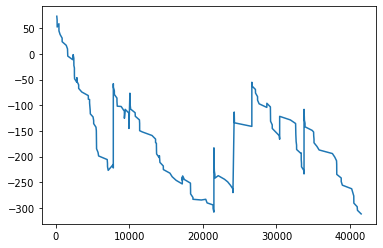

In [1067]:
params = res_gp.x_iters[100]
categories = df['sub_category'].value_counts().index[0:5]

for cat in categories:
    params = [0.00046533521175744073, 0.782485432655757, 1, 1, cat, 5, 0, 22.647943321888107, 51.39578561782152]
    print(cat, params, ff(params))

    from matplotlib import pyplot as plt

    g['stash'] = g['profit'].cumsum()
    print('races', len(g))
    print(g['start_at'].min(), g['start_at'].max())
    print(g[['start_at', 'horse_name', 'race_id', 'prize', 'bet', 'odds_n', 'sub_category', 'final_odds', 'winner_dividend', 'placed_dividend', 'position', 'bet', 'profit', 'stash']].head(10))
    g['stash'].plot()
    plt.show()

In [848]:
categories

['INCONNU',
 'COURSE_A_CONDITIONS',
 'AUTOSTART',
 'HANDICAP',
 'HANDICAP_DIVISE',
 'A_RECLAMER',
 'NATIONALE',
 'APPRENTIS_LADS_JOCKEYS',
 'EUROPEENNE',
 'HANDICAP_CATEGORIE_DIVISE']

In [1042]:
from dill import dump, load

MODEL_PATH = '/Users/pourquoi/workspace/cataclop/cataclop-django/var/models/keras-pair-pos3/'

#model.load_weights('/tmp/weights.best.hdf5')
#dump(model.get_weights(), open('/tmp/weights.pkl', 'wb'))

from dill import dump, load

dump(scaler, open(MODEL_PATH + 'scaler.pkl', 'wb+'))
model.save(MODEL_PATH + 'model.h5')

dump(horse_dummies, open(MODEL_PATH + 'horse_dummies.pkl', 'wb'))
dump(race_dummies, open(MODEL_PATH + 'race_dummies.pkl', 'wb'))



In [498]:
h = df_test

for n in range(1, 4):
    print(n)
    print('win % for pred number #')
    for i in range(20):
        p = 'pred_n{}'.format(n)
        if len(h[ (h[p]==i) & (h['position'] > 3)]):
            print(i, len(h[ (h[p]==i) & (h['position'] == 1)]) / len(h[ (h[p]==i) & (h['position'] != 1)]))
            print( len(h[ (h[p]==i) ]) )
            print( h[ (h[p]==i) ]['profit'].mean() )
            print('')
    

1
win % for pred number #
0 0.16395774075579034
5729
-0.26367603421190433

1 0.14168991630131528
5729
-0.21361494152557164

2 0.11960132890365449
5729
-0.2672194100192006

3 0.1026184058529072
5727
-0.2618299284092893

4 0.09080503624570775
5718
-0.27070654074851347

5 0.08693149107656879
5664
-0.31128177966101694

6 0.08781645569620253
5500
-0.16534545454545455

7 0.07474120082815736
5191
-0.255210942015026

8 0.0607350963693411
4733
-0.30029579547855484

9 0.06826706676669167
4272
-0.29063670411985015

10 0.06824754193175246
3694
-0.10197617758527343

11 0.048983672109296904
3148
-0.4028271918678526

12 0.05680868838763575
2530
-0.2522529644268775

13 0.05806783144912641
2059
-0.32850898494414765

14 0.04953338119167265
1462
-0.34534883720930226

15 0.0548604427333975
1096
-0.46560218978102186

16 0.06310679611650485
438
0.1958904109589041

17 0.0528169014084507
299
-0.18829431438127095

18 0.058823529411764705
36
-0.21388888888888888

19 0.08333333333333333
26
-0.6846153846153846

2

In [503]:
from matplotlib import pyplot as plt

def visu(graph=False):
    for cat in df_test['sub_category'].value_counts().index:
        print(cat)
        g = df_test[ (df_test['pred_std2'] > 0.0) & (df_test['pred_n2'] >= 0) & (df_test['pred_n2'] <= 2) & (df_test['sub_category']==cat) & (df_test['final_odds'] > 20) & (df_test['final_odds'] < 40) ].copy()

        if not graph:
            print(g['profit'].describe())
        else:
            g['stash'] = g['profit'].cumsum()
            print(len(g))
            print(g[['start_at', 'horse_name', 'race_id', 'prize', 'bet', 'odds_n', 'sub_category', 'final_odds', 'winner_dividend', 'placed_dividend', 'position', 'bet', 'profit', 'stash']].head(10))
            g['stash'].plot()
            plt.show()

In [504]:
visu(False)

INCONNU
count    301.000000
mean      -0.296013
std        4.286481
min       -1.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max       29.800000
Name: profit, dtype: float64
COURSE_A_CONDITIONS
count    255.000000
mean      -0.224706
std        4.790918
min       -1.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max       38.100000
Name: profit, dtype: float64
AUTOSTART
count    212.000000
mean      -0.217453
std        4.621578
min       -1.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max       30.100000
Name: profit, dtype: float64
HANDICAP
count    380.00000
mean       0.36000
std        6.22551
min       -1.00000
25%       -1.00000
50%       -1.00000
75%       -1.00000
max       36.80000
Name: profit, dtype: float64
HANDICAP_DIVISE
count    411.000000
mean      -0.316302
std        4.440303
min       -1.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max       37.600000
Name: profit, dtype: float64


INCONNU
114
                start_at          horse_name  race_id     prize  bet  odds_n  \
18   2018-01-02 13:12:00      FIERTE D'AUNOU    11117  0.697484    1       7   
874  2018-01-04 17:05:00    EMARA DU GOUTIER    11199  1.561412    1       7   
1457 2018-01-01 11:12:00          CUDGEE BOY    13550 -1.894959    1       9   
2925 2018-01-07 12:35:00        DYNAMITE FAC    13674 -0.202554    1       8   
3301 2018-01-08 16:31:00           ESPERANZO    13712  1.561412    1       8   
3311 2018-01-08 17:01:00      CYGA DE VANDEL    13713  1.038111    1       6   
3937 2018-01-09 18:17:00      DALI BOURGEOIS    13764 -0.131316    1       6   
3966 2018-01-09 19:17:00  CARLOTTA DU BOCAGE    13766 -0.131316    1       8   
4137 2018-01-10 14:58:00          ASAP POWER    13780  0.585794    1       7   
4435 2018-01-11 15:55:00   BOLIDE DE LA COTE    13806  0.661355    1       5   

     sub_category  final_odds  winner_dividend  placed_dividend  position  \
18        INCONNU        27.2 

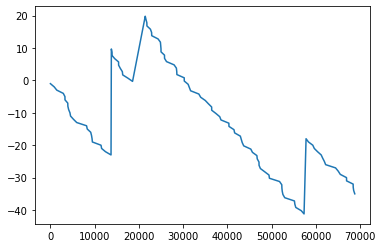

COURSE_A_CONDITIONS
59
                 start_at       horse_name  race_id     prize  bet  odds_n  \
3145  2018-01-07 19:03:00       MINA CHOPE    13692 -0.863883    1       6   
3379  2018-01-08 12:25:00        ENIVRANTE    13720  0.585794    1      11   
5748  2018-01-13 21:00:00      FLYING LORD    13923 -2.725440    1       9   
7119  2018-01-17 11:30:00        AKBAR JAY    14046 -0.717978    1       6   
7723  2018-01-18 14:05:00    LE PROFESSEUR    14098 -0.131316    1       9   
8018  2018-01-19 14:20:00     ULTRA PETITA    14123  0.227237    1       6   
9284  2018-01-21 21:10:00           ANDRIU    14246 -1.923209    1       7   
11080 2018-01-25 21:40:00      NAITA E FEO    14400 -0.502295    1       8   
11095 2018-01-25 19:30:00      ATTICUS BOY    14401 -1.000048    1       5   
12008 2018-01-27 19:45:00  DONCELLA VESTAL    14483 -2.160820    1       6   

              sub_category  final_odds  winner_dividend  placed_dividend  \
3145   COURSE_A_CONDITIONS        26.5    

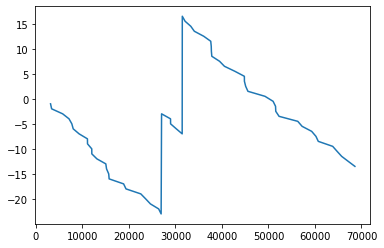

AUTOSTART
85
                 start_at       horse_name  race_id     prize  bet  odds_n  \
755   2018-01-03 20:06:00         ELEOS YC    11181 -2.172161    1       9   
5165  2018-01-12 18:15:00      SHAKE HANDS    13870 -1.381722    1       6   
7527  2018-01-17 19:25:00        VICTORIUS    14077 -2.005771    1       5   
8380  2018-01-19 19:47:00  CALL HIM GEORGE    14154 -1.608932    1       6   
8392  2018-01-19 20:43:00         CAMELEON    14156 -1.727705    1       5   
9040  2018-01-21 18:04:00  EXPRESS EVENING    14217  0.799984    1       7   
9412  2018-01-22 11:10:00     SPEEDY RAMBO    14257 -1.894959    1       8   
10561 2018-01-24 18:17:00  VINABEL BINIATI    14351 -1.858999    1      11   
11598 2018-01-26 20:00:00      GENTLY BOKO    14446 -1.381722    1       6   
12316 2018-01-28 11:30:00  FRANCE DE VALNY    14507  0.118790    1       3   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
755      AUTOSTART        26.6              0.0   

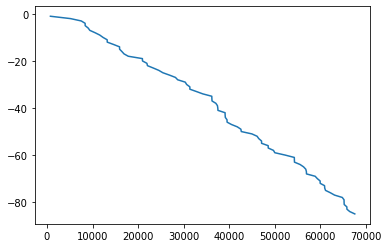

HANDICAP
22
                 start_at        horse_name  race_id     prize  bet  odds_n  \
1620  2018-01-01 19:04:00     NOBLE GALILEO    13565 -1.308393    1       6   
4250  2018-01-10 12:45:00  CALIFORNIA ASPAR    13791  1.953362    1       8   
4671  2018-01-11 16:40:00         WILD DUDE    13826  2.177924    1       6   
6670  2018-01-16 13:10:00    FIRST MENANTIE    14007  0.118790    1       5   
7814  2018-01-18 16:40:00         WILD DUDE    14105  2.082002    1       8   
9261  2018-01-21 20:15:00      SONG OF BABY    14244 -2.814569    1       7   
11110 2018-01-25 20:30:00            MILORD    14403 -1.202630    1       5   
14200 2018-02-01 17:15:00         WILD DUDE    14668  2.177924    1       4   
14740 2018-02-02 19:30:00          PRESENCE    14725 -1.727705    1       6   
16261 2018-02-05 19:29:00      AUTUMN TONIC    14849 -2.005771    1       5   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
1620      HANDICAP        20.7          

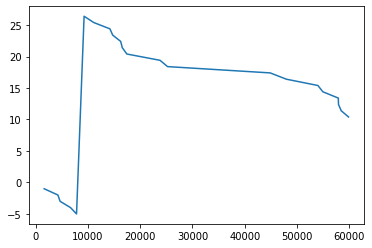

HANDICAP_DIVISE
1
                 start_at        horse_name  race_id     prize  bet  odds_n  \
64973 2018-05-20 18:15:00  COLONEL D'AUMONT    19114  1.283288    1      12   

          sub_category  final_odds  winner_dividend  placed_dividend  \
64973  HANDICAP_DIVISE        27.6              0.0              0.0   

       position  bet  profit  stash  
64973       6.0    1    -1.0   -1.0  


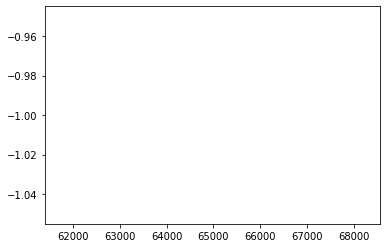

A_RECLAMER
4
                 start_at          horse_name  race_id     prize  bet  odds_n  \
9355  2018-01-22 14:50:00      STORMY DESTINY    14252 -0.278113    1      11   
25894 2018-02-27 18:43:00  DOMINO DE LA CROIX    15702 -0.444537    1       8   
53622 2018-04-27 12:55:00           HAPPY FOX    18115  0.374037    1       6   
54236 2018-04-28 19:13:00               CLINT    18180 -0.202554    1       5   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
9355    A_RECLAMER        29.7              0.0              0.0      12.0   
25894   A_RECLAMER        23.1              0.0              0.0      20.0   
53622   A_RECLAMER        29.7              0.0              0.0       6.0   
54236   A_RECLAMER        25.1              0.0              0.0       4.0   

       bet  profit  stash  
9355     1    -1.0   -1.0  
25894    1    -1.0   -2.0  
53622    1    -1.0   -3.0  
54236    1    -1.0   -4.0  


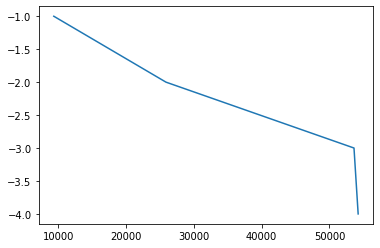

EUROPEENNE
15
                 start_at          horse_name  race_id     prize  bet  odds_n  \
4480  2018-01-11 17:35:00       UNGOLD WINNER    13809  0.624147    1       4   
7360  2018-01-17 16:40:00          BOOGIE BOY    14064  0.419365    1       7   
12447 2018-01-28 17:38:00       UNIQUE D'HUON    14516  0.278116    1       6   
17545 2018-02-09 14:20:00          CAVALLERIA    14970  1.727845    1       7   
27169 2018-03-02 19:40:00          UP AND WIN    15824  0.374037    1       5   
31342 2018-03-11 17:45:00  VELVET UNDERGROUND    16183  0.863915    1       9   
31666 2018-03-12 13:25:00     BETTINA D'AVRIL    16216  0.585794    1       7   
34738 2018-03-18 14:52:00       BALOU DU PAOU    16481  0.278116    1       9   
41636 2018-04-01 17:00:00    PICARD DEL RONCO    17085  0.697484    1       7   
42911 2018-04-04 18:35:00       COOBYA ANGANO    17198  0.118790    1       7   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
4480    EUROPEEN

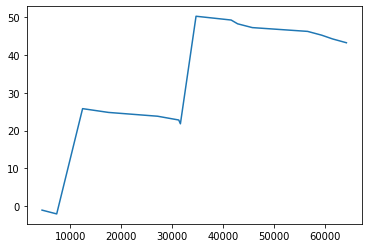

NATIONALE
32
                 start_at          horse_name  race_id     prize  bet  odds_n  \
16315 2018-02-06 14:22:00     EXOCET DU START    14855  0.863915    1       7   
20294 2018-02-14 20:44:00    FAN DE VINCENNES    15203  0.060810    1       8   
21823 2018-02-18 13:35:00   DAME DU COURTILLE    15339  0.118790    1      11   
24820 2018-02-24 19:54:00     DUSTY DE BEYLEV    15593  0.060810    1       6   
25053 2018-02-25 13:05:00  ESMERALDA DE COSSE    15611 -0.202554    1       9   
25081 2018-02-25 14:10:00       EDEN DU BERRE    15613 -0.202554    1       6   
26877 2018-03-02 15:20:00         ESPRIT DELO    15797  0.863915    1       6   
29796 2018-03-08 14:05:00      FAYA TREVEENNE    16053 -0.131316    1       9   
32430 2018-03-14 16:10:00    FATALE DE BOUERE    16281 -0.278113    1       9   
33140 2018-03-15 15:11:00  DORENZO DU HOULBET    16343  0.118790    1       9   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
16315    NATIONAL

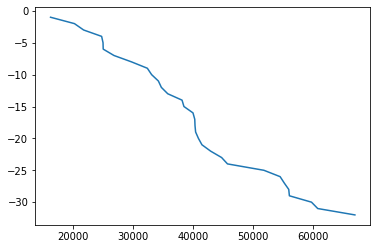

INTERNATIONALE_AUTOSTART
28
                 start_at       horse_name  race_id     prize  bet  odds_n  \
1695  2018-01-01 20:15:00        ULA ROWER    13574 -2.005771    1       7   
2432  2018-01-06 13:05:00         OMERO BI    13636 -1.727705    1       8   
5443  2018-01-13 11:05:00  DOLLY DU QUESNE    13895 -1.858999    1       5   
5454  2018-01-13 11:35:00    EINSTEIN (NL)    13896 -1.858999    1       7   
6933  2018-01-16 20:50:00      ALEZAN ROSE    14029 -1.631798    1       5   
8584  2018-01-20 13:05:00          FLORIAN    14179 -1.858999    1       6   
10665 2018-01-24 19:25:00           KRABAT    14360 -2.005771    1       6   
10689 2018-01-24 20:55:00           LOUISA    14363 -1.858999    1       6   
14956 2018-02-03 10:50:00          EPHRAIM    14745 -2.005771    1       5   
14990 2018-02-03 12:23:00          FLORIAN    14748 -1.858999    1       6   

                   sub_category  final_odds  winner_dividend  placed_dividend  \
1695   INTERNATIONALE_AUTOSTART 

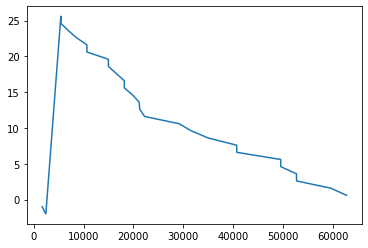

HANDICAP_CATEGORIE_DIVISE
2
                 start_at   horse_name  race_id     prize  bet  odds_n  \
38621 2018-03-26 17:45:00    SNEJINSKA    16819 -0.444537    1       8   
57570 2018-05-05 13:22:00  WHOWASRIGHT    18469 -0.063929    1      11   

                    sub_category  final_odds  winner_dividend  \
38621  HANDICAP_CATEGORIE_DIVISE        24.5              0.0   
57570  HANDICAP_CATEGORIE_DIVISE        20.9              0.0   

       placed_dividend  position  bet  profit  stash  
38621              0.0       9.0    1    -1.0   -1.0  
57570              0.0      18.0    1    -1.0   -2.0  


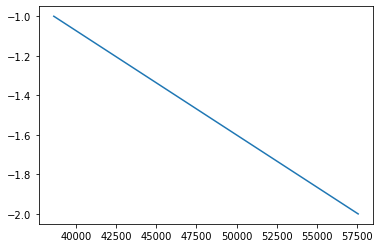

APPRENTIS_LADS_JOCKEYS
14
                 start_at          horse_name  race_id     prize  bet  odds_n  \
2046  2018-01-05 19:42:00        COOPER GIBUS    13604 -0.202554    1       7   
3995  2018-01-09 20:25:00            DEXTERIA    13768 -0.131316    1       7   
13777 2018-01-31 19:13:00             DYNALYX    14632 -0.131316    1       6   
16000 2018-02-05 12:25:00     VIVE LE LOUFIAT    14831  0.118790    1       6   
17206 2018-02-08 17:30:00     CYCLONE D'AMARO    14936  1.369280    1       6   
28024 2018-03-04 13:15:00   BEN HUR D'UGGATTE    15897 -0.131316    1       8   
35040 2018-03-19 12:55:00       BARRACUDA LAP    16518  0.000000    1       7   
38881 2018-03-27 12:55:00   CYBELE DE L'AUNEY    16842  0.118790    1      11   
41342 2018-04-01 12:50:00      CYRIUS DE JADE    17051  0.060810    1       5   
44479 2018-04-08 11:20:00  BHOUTAN DU PATURAL    17331  0.060810    1       7   

                 sub_category  final_odds  winner_dividend  placed_dividend  \
204

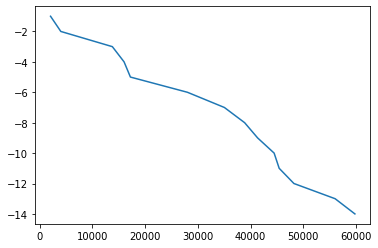

AMATEURS
13
                 start_at          horse_name  race_id     prize  bet  odds_n  \
7463  2018-01-17 20:40:00      VINCI DU LILAS    14072 -1.500499    1       6   
9810  2018-01-22 21:00:00   VICTOIRE DES BOTS    14286 -1.500499    1       8   
20738 2018-02-16 14:20:00                AZUR    15250 -1.141981    1       8   
28009 2018-03-04 14:42:00  CEDILLE D'AVIGNERE    15896 -1.500499    1       6   
34004 2018-03-16 21:45:00   AZUR DE CLERLANDE    16412 -1.500499    1       8   
35733 2018-03-20 22:47:00       ARISTA DE MYE    16577 -0.444537    1       8   
39211 2018-03-27 22:45:00        COCKTAIL WAY    16870 -0.444537    1       8   
48678 2018-04-16 14:05:00               AZURO    17681 -1.500499    1       7   
49387 2018-04-17 22:47:00   BINIOU DU BEUVRON    17738 -0.444537    1       8   
51188 2018-04-21 16:35:00      ASSWORD DE BEA    17898 -1.727705    1       7   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
7463      AMATEURS

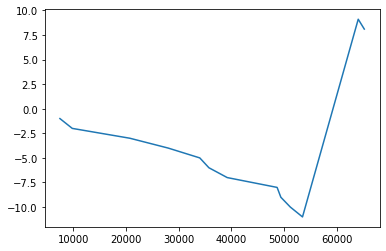

NATIONALE_AUTOSTART
10
                 start_at          horse_name  race_id     prize  bet  odds_n  \
24856 2018-02-24 21:22:00       FLAIRSOU GAME    15596  0.060810    1       5   
29249 2018-03-07 17:02:00        EVA DU DERBY    16000  0.000000    1       9   
35371 2018-03-20 12:25:00   FLAMENCO DE GINAI    16548 -0.278113    1       6   
37895 2018-03-25 11:20:00     FIBRE DU CLOSET    16760  0.118790    1       4   
38001 2018-03-25 14:51:00    DOSSARIE DE GUEZ    16767  0.000000    1       5   
39315 2018-03-28 17:02:00           DEMOCRATE    16877  0.118790    1       5   
46347 2018-04-12 14:05:00   ESPERANCE CELESTE    17490  0.000000    1       8   
60499 2018-05-11 13:25:00  FRISSON D'OCCAGNES    18731  0.000000    1       8   
62937 2018-05-16 20:10:00           FROMENTIN    18949 -0.063929    1       6   
66321 2018-05-23 17:31:00        DUC DE LARRE    19235  0.118790    1       8   

              sub_category  final_odds  winner_dividend  placed_dividend  \
24856  NA

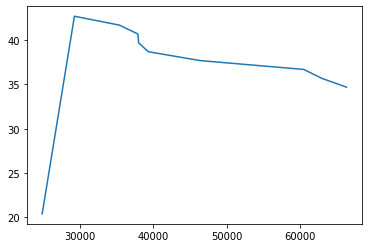

HANDICAP_DE_CATEGORIE
1
                 start_at horse_name  race_id     prize  bet  odds_n  \
68787 2018-05-28 15:40:00    CELTIOR    19482  0.174193    1       6   

                sub_category  final_odds  winner_dividend  placed_dividend  \
68787  HANDICAP_DE_CATEGORIE        20.3              0.0              0.0   

       position  bet  profit  stash  
68787      20.0    1    -1.0   -1.0  


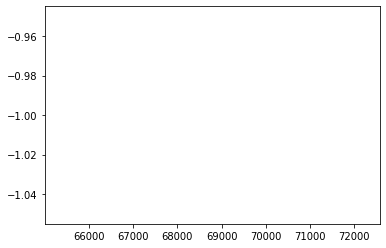

EUROPEENNE_AUTOSTART
4
                 start_at         horse_name  race_id     prize  bet  odds_n  \
26019 2018-02-28 13:47:00    VIC DE LA FERME    15713  1.260830    1      10   
34902 2018-03-18 16:30:00       ETOILE ROUGE    16501 -0.358549    1      12   
50270 2018-04-20 20:42:00           DECENNIE    17810  1.596524    1       6   
56820 2018-05-04 20:15:00  AZUR DES CAILLONS    18407  1.091157    1      11   

               sub_category  final_odds  winner_dividend  placed_dividend  \
26019  EUROPEENNE_AUTOSTART        36.8              0.0              0.0   
34902  EUROPEENNE_AUTOSTART        31.2              0.0              0.0   
50270  EUROPEENNE_AUTOSTART        20.7              0.0              0.0   
56820  EUROPEENNE_AUTOSTART        35.4           3540.0            720.0   

       position  bet  profit  stash  
26019      20.0    1    -1.0   -1.0  
34902      20.0    1    -1.0   -2.0  
50270       4.0    1    -1.0   -3.0  
56820       1.0    1    34.4   31.4  


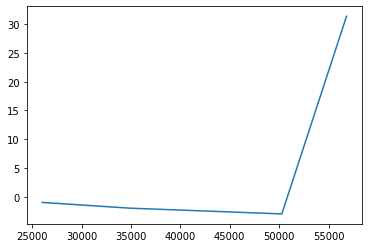

GROUPE_III
2
                 start_at      horse_name  race_id     prize  bet  odds_n  \
46719 2018-04-13 20:42:00  AVENIR DE BLAY    17519  2.180169    1       7   
46954 2018-04-13 14:20:00      FASTIDIOUS    17541  1.727845    1       7   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
46719   GROUPE_III        38.4              0.0              0.0       6.0   
46954   GROUPE_III        35.7              0.0              0.0       6.0   

       bet  profit  stash  
46719    1    -1.0   -1.0  
46954    1    -1.0   -2.0  


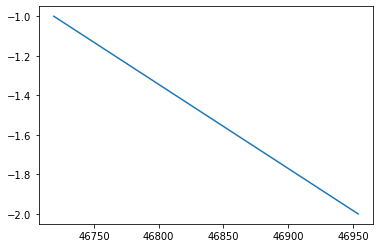

GROUPE_I
6
                 start_at  horse_name  race_id     prize  bet  odds_n  \
31304 2018-03-11 16:10:00    ANNA MIX    16180  2.869910    1       4   
34044 2018-03-16 16:30:00    AMERICAN    16415  4.432174    1      11   
47261 2018-04-13 15:20:00     BEDROCK    17564  2.148035    1      11   
47792 2018-04-14 07:05:00  GAILO CHOP    17607  6.088384    1       3   
47821 2018-04-14 07:45:00     DOUKHAN    17608  5.224439    1      10   
54453 2018-04-29 16:30:00      FINCHE    18207  4.239227    1       4   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
31304     GROUPE_I        27.4              0.0              0.0       5.0   
34044     GROUPE_I        35.0              0.0              0.0       9.0   
47261     GROUPE_I        31.6              0.0            530.0       3.0   
47792     GROUPE_I        22.7              0.0            110.0       2.0   
47821     GROUPE_I        26.0              0.0              0.0       7.0   
54453    

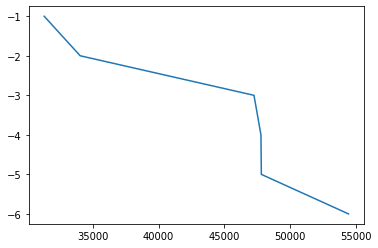

GROUPE_II
5
                 start_at        horse_name  race_id     prize  bet  odds_n  \
14770 2018-02-03 14:07:00       FINEST HOUR    14729  2.233215    1       6   
20442 2018-02-15 16:25:00  FLORAY VEDAQUAIS    15216  2.233215    1       6   
20458 2018-02-15 17:30:00     FIONA D'ATOUT    15218  2.233215    1       4   
23701 2018-02-22 15:30:00           FITYAAN    15501  2.501381    1       5   
52556 2018-04-24 21:55:00      FRISBEE D'AM    18012  2.233215    1       8   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
14770    GROUPE_II        34.6              0.0              0.0       5.0   
20442    GROUPE_II        26.5              0.0              0.0       5.0   
20458    GROUPE_II        21.3              0.0              0.0      20.0   
23701    GROUPE_II        28.8              0.0              0.0       5.0   
52556    GROUPE_II        28.2              0.0              0.0       8.0   

       bet  profit  stash  
14770    1    -1

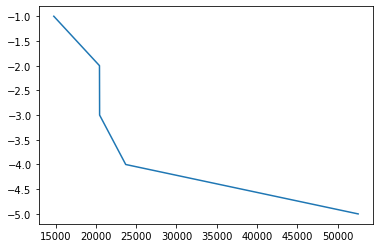

AMATEURS_AUTOSTART
4
                 start_at          horse_name  race_id     prize  bet  odds_n  \
11497 2018-01-26 18:45:00   VITO DES LANDIERS    14437 -1.141981    1       8   
11622 2018-01-26 21:28:00  GWENDA BEUCKENSWYK    14449 -1.608932    1       6   
24425 2018-02-23 21:35:00    VAS Y DONC PARIS    15561 -1.141981    1       8   
45757 2018-04-10 22:25:00         ATMAN DE BA    17440 -0.444537    1       5   

             sub_category  final_odds  winner_dividend  placed_dividend  \
11497  AMATEURS_AUTOSTART        26.1              0.0              0.0   
11622  AMATEURS_AUTOSTART        24.6              0.0              0.0   
24425  AMATEURS_AUTOSTART        24.8              0.0              0.0   
45757  AMATEURS_AUTOSTART        21.4              0.0            430.0   

       position  bet  profit  stash  
11497       9.0    1    -1.0   -1.0  
11622       4.0    1    -1.0   -2.0  
24425       5.0    1    -1.0   -3.0  
45757       3.0    1    -1.0   -4.0  


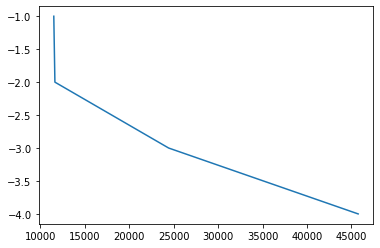

APPRENTIS_LADS_JOCKEYS_AUTOSTART
4
                 start_at         horse_name  race_id     prize  bet  odds_n  \
24834 2018-02-24 20:24:00  BAROUDEUR DU CAUX    15594  0.060810    1       6   
25921 2018-02-27 19:12:00              BINGO    15703  0.326999    1       7   
39300 2018-03-28 16:30:00             VERJUS    16876  0.000000    1       7   
65866 2018-05-22 12:55:00         AMUSE NOUS    19198  0.000000    1       6   

                           sub_category  final_odds  winner_dividend  \
24834  APPRENTIS_LADS_JOCKEYS_AUTOSTART        23.7              0.0   
25921  APPRENTIS_LADS_JOCKEYS_AUTOSTART        37.9              0.0   
39300  APPRENTIS_LADS_JOCKEYS_AUTOSTART        27.8              0.0   
65866  APPRENTIS_LADS_JOCKEYS_AUTOSTART        21.0              0.0   

       placed_dividend  position  bet  profit  stash  
24834              0.0       7.0    1    -1.0   -1.0  
25921              0.0       8.0    1    -1.0   -2.0  
39300              0.0      14.0    1 

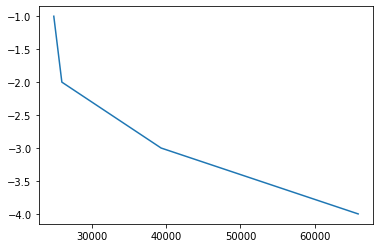

INTERNATIONALE
5
                 start_at        horse_name  race_id     prize  bet  odds_n  \
327   2018-01-02 17:57:00         BY VIVANT    11141 -1.273286    1       6   
8539  2018-01-20 11:05:00        GULIANO BO    14175 -1.727705    1       4   
30897 2018-03-10 18:15:00     USTANG LUDOIS    16147  0.863915    1       8   
55164 2018-04-30 12:40:00  DOUCE ROSE AMOUR    18269 -1.608932    1       9   
59562 2018-05-09 11:40:00            ORAGOS    18647 -1.141981    1       3   

         sub_category  final_odds  winner_dividend  placed_dividend  position  \
327    INTERNATIONALE        32.5              0.0              0.0       6.0   
8539   INTERNATIONALE        35.3              0.0              0.0       8.0   
30897  INTERNATIONALE        32.4              0.0              0.0       6.0   
55164  INTERNATIONALE        37.2              0.0              0.0       8.0   
59562  INTERNATIONALE        20.6              0.0              0.0      20.0   

       bet  profit  s

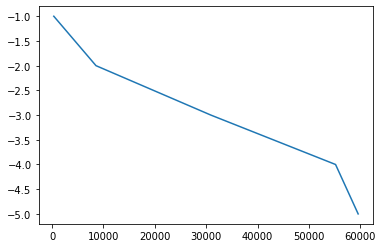

COURSE_A_CONDITION_QUALIF_HP
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, odds_n, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


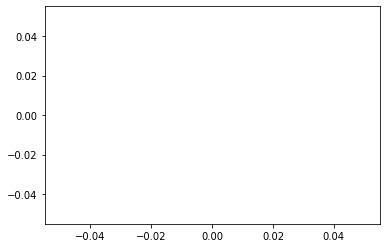

APPRENTIS_LADS_JOCKEYS_EUROPEENNE
2
                 start_at          horse_name  race_id     prize  bet  odds_n  \
4503  2018-01-11 12:25:00  UNIVERS D'OLIVERIE    13815  0.227237    1       7   
35792 2018-03-21 14:23:00   BRUME DE LA BRISE    16581  0.118790    1       5   

                            sub_category  final_odds  winner_dividend  \
4503   APPRENTIS_LADS_JOCKEYS_EUROPEENNE        32.1              0.0   
35792  APPRENTIS_LADS_JOCKEYS_EUROPEENNE        21.6              0.0   

       placed_dividend  position  bet  profit  stash  
4503               0.0      12.0    1    -1.0   -1.0  
35792              0.0       8.0    1    -1.0   -2.0  


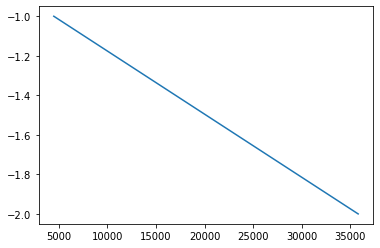

A_RECLAMER_AUTOSTART
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, odds_n, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


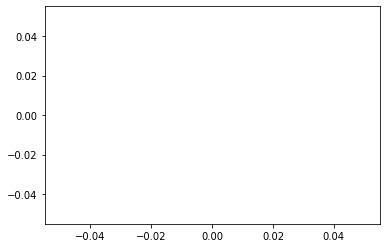

APPRENTIS_LADS_JOCKEYS_A_RECLAMER_AUTOSTART
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, odds_n, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


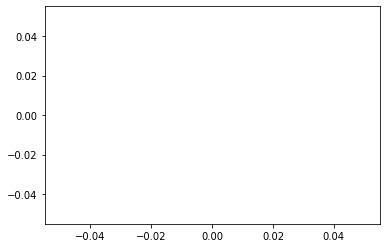

A_RECLAMER_APPRENTIS_LADS_JOCKEYS
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, odds_n, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


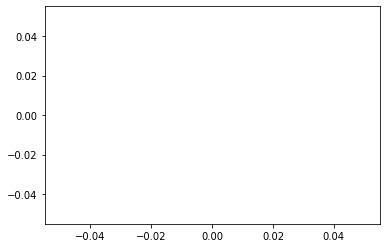

AMATEURS_NATIONALE
2
                 start_at    horse_name  race_id     prize  bet  odds_n  \
52616 2018-04-25 14:20:00  CAIMAN FAWEY    18023 -1.141981    1       9   
66234 2018-05-23 14:20:00  BIJOU DU REZ    19229 -1.141981    1       8   

             sub_category  final_odds  winner_dividend  placed_dividend  \
52616  AMATEURS_NATIONALE        22.5              0.0              0.0   
66234  AMATEURS_NATIONALE        25.5              0.0              0.0   

       position  bet  profit  stash  
52616      20.0    1    -1.0   -1.0  
66234      10.0    1    -1.0   -2.0  


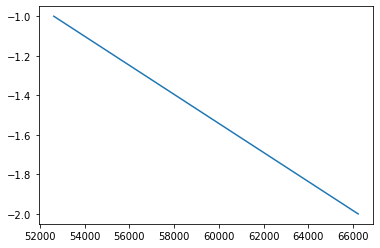

AMATEURS_INTERNATIONALE_AUTOSTART
1
                 start_at     horse_name  race_id     prize  bet  odds_n  \
55137 2018-04-30 11:40:00  GHICKADEE HPK    18267 -2.005771    1       7   

                            sub_category  final_odds  winner_dividend  \
55137  AMATEURS_INTERNATIONALE_AUTOSTART        20.7              0.0   

       placed_dividend  position  bet  profit  stash  
55137            510.0       3.0    1    -1.0   -1.0  


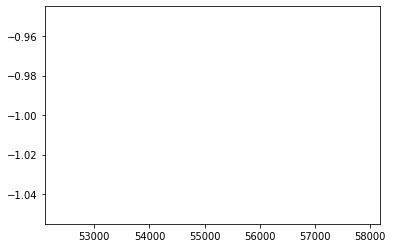

COURSE_AP
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, odds_n, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


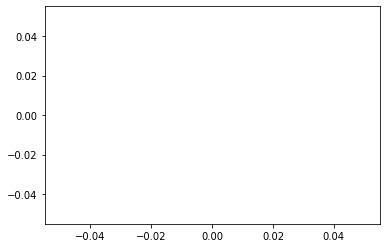

AMATEURS_EUROPEENNE_AUTOSTART
1
                 start_at         horse_name  race_id     prize  bet  odds_n  \
54214 2018-04-28 20:25:00  BERLIOZ DE L'ITON    18178 -1.500499    1       7   

                        sub_category  final_odds  winner_dividend  \
54214  AMATEURS_EUROPEENNE_AUTOSTART        36.0              0.0   

       placed_dividend  position  bet  profit  stash  
54214            510.0       3.0    1    -1.0   -1.0  


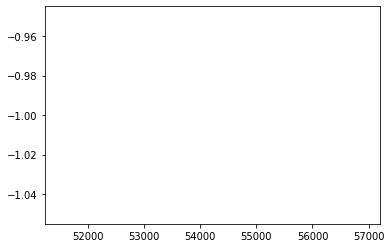

QUALIFICATION_ACCAF
1
                 start_at  horse_name  race_id     prize  bet  odds_n  \
50693 2018-04-20 18:15:00  JAMAS D.A.    17845  0.278116    1       6   

              sub_category  final_odds  winner_dividend  placed_dividend  \
50693  QUALIFICATION_ACCAF        38.4              0.0              0.0   

       position  bet  profit  stash  
50693       7.0    1    -1.0   -1.0  


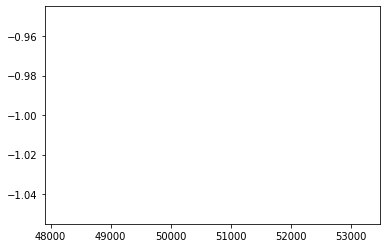

HANDICAP_A_RECLAMER
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, odds_n, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


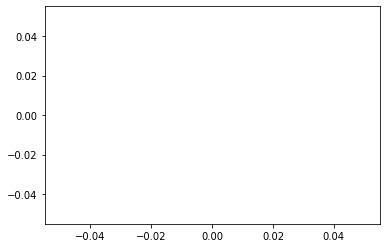

AMATEURS_INTERNATIONALE
1
                start_at horse_name  race_id     prize  bet  odds_n  \
9495 2018-01-22 13:25:00  FINAL OAK    14264 -0.278113    1       9   

                 sub_category  final_odds  winner_dividend  placed_dividend  \
9495  AMATEURS_INTERNATIONALE        38.4              0.0              0.0   

      position  bet  profit  stash  
9495       6.0    1    -1.0   -1.0  


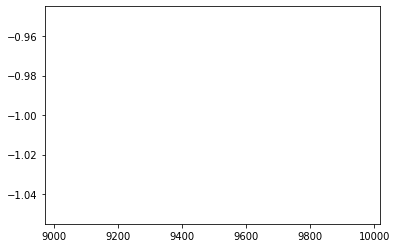

A_RECLAMER_AMATEURS
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, odds_n, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


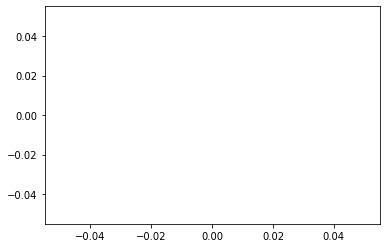

A_RECLAMER_AMATEURS_AUTOSTART
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, odds_n, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


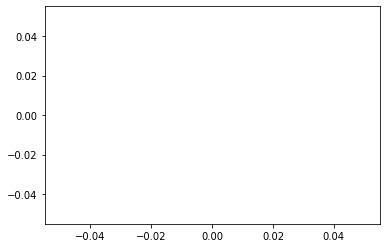

AMATEURS_PRIORITE_AUX_PROPRIETAIRES
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, odds_n, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


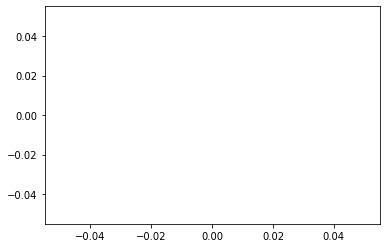

COURSE_INTERNATIONALE
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, odds_n, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


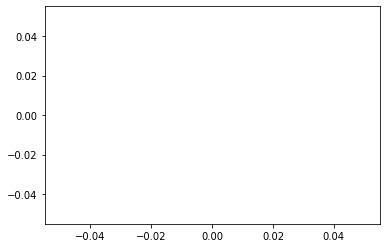

FINALE_REGIONALE_ACCAF
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, odds_n, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


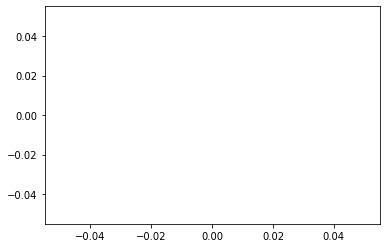

AMATEURS_EUROPEENNE
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, odds_n, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


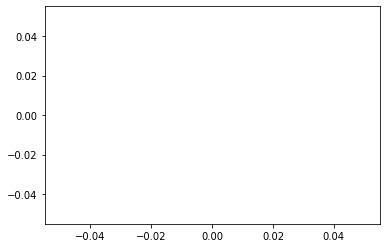

AMATEURS_DAMES_AUTOSTART
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, odds_n, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


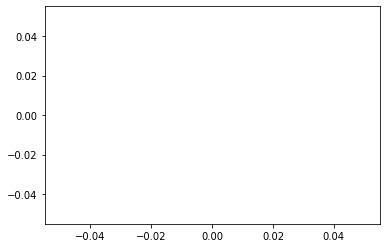

MIXTE
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, odds_n, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


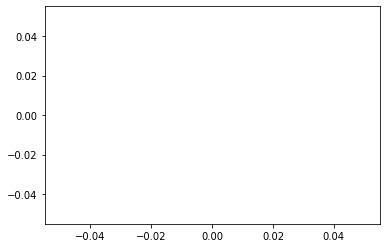

COURSE_AP_EUROPEENNE
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, odds_n, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


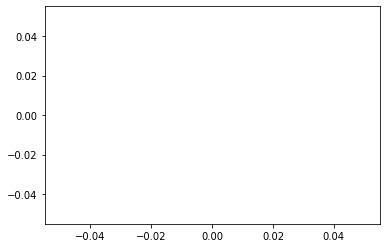

In [428]:
visu(True)